In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import yfinance as yf
import time
import seaborn as sns
from scipy.stats import norm
import tensorflow as tf
from keras.layers import Input, Embedding, LSTM, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras.utils import plot_model,pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing.text import Tokenizer
from tensorflow.keras import Model, Input, layers, metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout, BatchNormalization
import pandas as pd

In [ ]:
#read csv files

hot_finbert = pd.read_csv('drive/MyDrive/Dissertation/CSV/hot_finbert_ret.csv')
hot_chatgpt = pd.read_csv('drive/MyDrive/Dissertation/CSV/hot_chatgpt_ret.csv')
hot_roberta = pd.read_csv('drive/MyDrive/Dissertation/CSV/hot_roberta_ret.csv')
new_finbert = pd.read_csv('drive/MyDrive/Dissertation/CSV/new_finbert_ret.csv')
new_chatgpt = pd.read_csv('drive/MyDrive/Dissertation/CSV/new_chatgpt_ret.csv')
new_roberta = pd.read_csv('drive/MyDrive/Dissertation/CSV/new_roberta_ret.csv')
hot_vader = pd.read_csv('drive/MyDrive/Dissertation/CSV/hot_vader_ret.csv')
new_vader = pd.read_csv('drive/MyDrive/Dissertation/CSV/new_vader_ret.csv')


In [ ]:
def plot_loss_and_accuracy(history):
    fig, axs = plt.subplots(1, 2, figsize=(12,5))

    # Plot training & validation accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()


In [ ]:
def plot_week_eval(accuracy,precision,recall,loss):
  labels = ['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5']
  fig, axes = plt.subplots(2, 2, figsize=(18, 12))
  # Accuracy
  axes[0, 0].plot(labels, accuracy, marker='o')
  axes[0, 0].set_title('Accuracy')
  axes[0, 0].grid(True)
  # Precision
  axes[0, 1].plot(labels, precision, marker='o')
  axes[0, 1].set_title('Precision')
  axes[0, 1].grid(True)
  #Recall
  axes[1, 0].plot(labels, recall, marker='o')
  axes[1, 0].set_title('Recall')
  axes[1, 0].grid(True)
  #Loss
  axes[1, 1].plot(labels, loss, marker='o')
  axes[1, 1].set_title('Loss')
  axes[1, 1].grid(True)

  plt.show()


In [ ]:
def model_LSTM_weekly(df, return_day, max_words=10000):
    # Preprocessing
    df['text'] = df['text'].astype(str)
    label_dummies = pd.get_dummies(df['label'], prefix='label')
    ticker_dummies = pd.get_dummies(df['ticker'], prefix='ticker')
    df = pd.concat([df, label_dummies, ticker_dummies], axis=1)
    df['score'] = df['score'].astype(float)

    # Feature and Target Variables
    X = df[['text'] + list(label_dummies.columns) + list(ticker_dummies.columns) + ['score', 'open', 'high', 'low', 'close', 'vol']]
    y = (df[f'ret_{return_day}'] > 0).astype(int)

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Text Tokenization and Padding
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train['text'])
    train_text_sequences = tokenizer.texts_to_sequences(X_train['text'])
    test_text_sequences = tokenizer.texts_to_sequences(X_test['text'])
    max_sequence_length = max(len(s) for s in train_text_sequences + test_text_sequences)
    train_text_padded = pad_sequences(train_text_sequences, maxlen=max_sequence_length)
    test_text_padded = pad_sequences(test_text_sequences, maxlen=max_sequence_length)

    # Model Inputs
    text_input = Input(shape=(max_sequence_length,), name='text_input')
    ticker_input = Input(shape=(len(ticker_dummies.columns),), name='ticker_input')
    label_input = Input(shape=(len(label_dummies.columns),), name='label_input')
    score_input = Input(shape=(1,), name='score_input')
    market_input = Input(shape=(5,), name='market_input')

    # Model Layers
    text_embedding = layers.Embedding(input_dim=max_words, output_dim=128)(text_input)
    text_lstm = layers.LSTM(128)(text_embedding)  # Removed the second LSTM layer and return_sequences=True
    text_dropout = Dropout(0.5)(text_lstm)

    market_dense = layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001))(market_input)
    market_dropout = Dropout(0.5)(market_dense)

    combined_inputs = layers.concatenate([text_dropout, ticker_input, label_input, score_input, market_dropout])

    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(combined_inputs)
    x = BatchNormalization()(x)
    x = layers.Dense(68, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    # Compile and Train Model
    model = Model(inputs=[text_input, ticker_input, label_input, score_input, market_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

    if return_day == 1:
      tf.keras.utils.plot_model(model, show_shapes=True)
      model.summary()
    history = model.fit(
        {'text_input': train_text_padded, 'ticker_input': X_train[ticker_dummies.columns].values,
         'label_input': X_train[label_dummies.columns].values, 'score_input': X_train['score'].values,
         'market_input': X_train[['open', 'high', 'low', 'close', 'vol']].values},
        y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2
    )
    # Plot loss and accuracy
    plot_loss_and_accuracy(history)

    # Evaluate the model
    evaluation = model.evaluate(
        {'text_input': test_text_padded, 'ticker_input': X_test[ticker_dummies.columns].values,
         'label_input': X_test[label_dummies.columns].values, 'score_input': X_test['score'].values,
         'market_input': X_test[['open', 'high', 'low', 'close', 'vol']].values},
        y_test
    )
    precision = evaluation[2]
    recall = evaluation[3]

    f1 = 2 * (precision * recall) / (precision + recall)
    print("Test Accuracy for Returns from day ", return_day, " : {:.2f}%".format(evaluation[1] * 100))
    print("Test Precision for Returns from day ", return_day, " : {:.2f}%".format(evaluation[2] * 100))
    print("Test Recall for Returns from day ", return_day, " : {:.2f}%".format(evaluation[3] * 100))
    print("Test Loss for Returns from day ", return_day, " : {:.4f}".format(evaluation[0]))
    print("Test F1 Score for Returns from day ", return_day, " : {:.2f}".format(f1 * 100))

    return evaluation


In [ ]:
def model_LSTM_weekly_vader(df, return_day, max_words=10000):
    # Preprocessing
    df['text'] = df['text'].astype(str)
    ticker_dummies = pd.get_dummies(df['ticker'], prefix='ticker')
    df = pd.concat([df, ticker_dummies], axis=1)

    # Feature and Target Variables
    X = df[['text'] + list(ticker_dummies.columns) + ['compound', 'open', 'high', 'low', 'close', 'vol']]
    y = (df[f'ret_{return_day}'] > 0).astype(int)

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Text Tokenization and Padding
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train['text'])
    train_text_sequences = tokenizer.texts_to_sequences(X_train['text'])
    test_text_sequences = tokenizer.texts_to_sequences(X_test['text'])
    max_sequence_length = max(len(s) for s in train_text_sequences + test_text_sequences)
    train_text_padded = pad_sequences(train_text_sequences, maxlen=max_sequence_length)
    test_text_padded = pad_sequences(test_text_sequences, maxlen=max_sequence_length)

    # Model Inputs
    text_input = Input(shape=(max_sequence_length,), name='text_input')
    ticker_input = Input(shape=(len(ticker_dummies.columns),), name='ticker_input')
    compound_input = Input(shape=(1,), name='compound_input')
    market_input = Input(shape=(5,), name='market_input')

    # Model Layers
    text_embedding = layers.Embedding(input_dim=max_words, output_dim=128)(text_input)
    text_lstm = layers.LSTM(128)(text_embedding)
    text_dropout = Dropout(0.5)(text_lstm)

    market_dense = layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001))(market_input)
    market_dropout = Dropout(0.5)(market_dense)

    combined_inputs = layers.concatenate([text_dropout, ticker_input, compound_input, market_dropout])

    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(combined_inputs)
    x = BatchNormalization()(x)
    x = layers.Dense(68, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    # Compile and Train Model
    model = Model(inputs=[text_input, ticker_input, compound_input, market_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

    if return_day == 1:
        tf.keras.utils.plot_model(model, show_shapes=True)
        model.summary()

    history = model.fit(
        {'text_input': train_text_padded, 'ticker_input': X_train[ticker_dummies.columns].values,
         'compound_input': X_train['compound'].values,
         'market_input': X_train[['open', 'high', 'low', 'close', 'vol']].values},
        y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2
    )
    plot_loss_and_accuracy(history)
    # Evaluate the model
    evaluation = model.evaluate(
        {'text_input': test_text_padded, 'ticker_input': X_test[ticker_dummies.columns].values,
         'compound_input': X_test['compound'].values,
         'market_input': X_test[['open', 'high', 'low', 'close', 'vol']].values},
        y_test
    )

    print("Test Accuracy for Returns from day ", return_day, " : {:.2f}%".format(evaluation[1] * 100))
    print("Test Precision for Returns from day ", return_day, " : {:.2f}%".format(evaluation[2] * 100))
    print("Test Recall for Returns from day ", return_day, " : {:.2f}%".format(evaluation[3] * 100))
    print("Test Loss for Returns from day ", return_day, " : {:.4f}".format(evaluation[0]))

    return evaluation


=============  HOT FINBERT LSTM  =============== 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 32)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 128)      1280000     ['text_input[0][0]']             
                                                                                                  
 market_input (InputLayer)      [(None, 5)]          0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          131584      ['embedding[0][0]']              
                                           

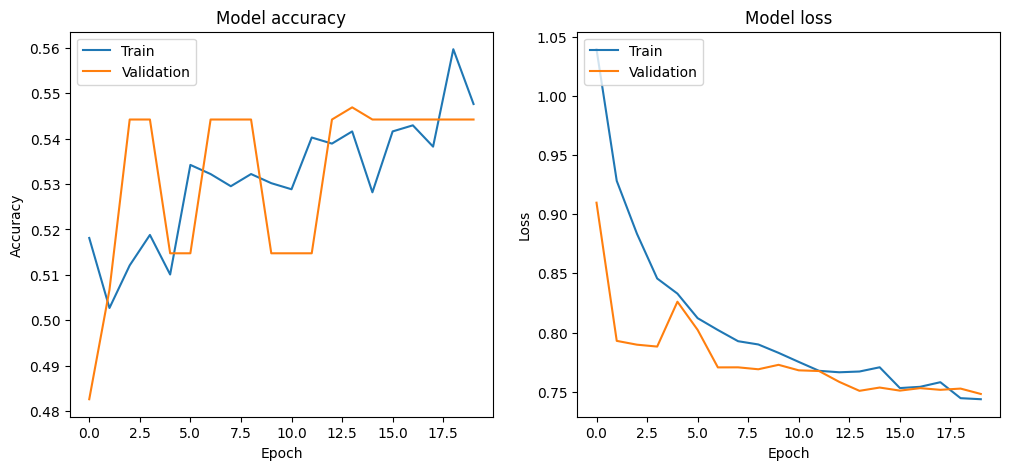

15/15 [==============================] - 0s 5ms/step - loss: 0.7414 - accuracy: 0.5815 - precision: 0.5700 - recall: 0.9084
Test Accuracy for Returns from day  1  : 58.15%
Test Precision for Returns from day  1  : 57.00%
Test Recall for Returns from day  1  : 90.84%
Test Loss for Returns from day  1  : 0.7414
Epoch 1/20
47/47 [==============================] - 13s 198ms/step - loss: 1.1054 - accuracy: 0.4973 - precision: 0.5251 - recall: 0.6181 - val_loss: 0.8441 - val_accuracy: 0.5013 - val_precision: 0.5087 - val_recall: 0.9115
Epoch 2/20
47/47 [==============================] - 4s 93ms/step - loss: 0.9286 - accuracy: 0.5107 - precision: 0.5390 - recall: 0.5817 - val_loss: 0.8034 - val_accuracy: 0.5496 - val_precision: 0.5390 - val_recall: 0.8646
Epoch 3/20
47/47 [==============================] - 3s 55ms/step - loss: 0.8775 - accuracy: 0.5174 - precision: 0.5446 - recall: 0.5905 - val_loss: 0.7819 - val_accuracy: 0.5147 - val_precision: 0.5797 - val_recall: 0.2083
Epoch 4/20
47/47 [

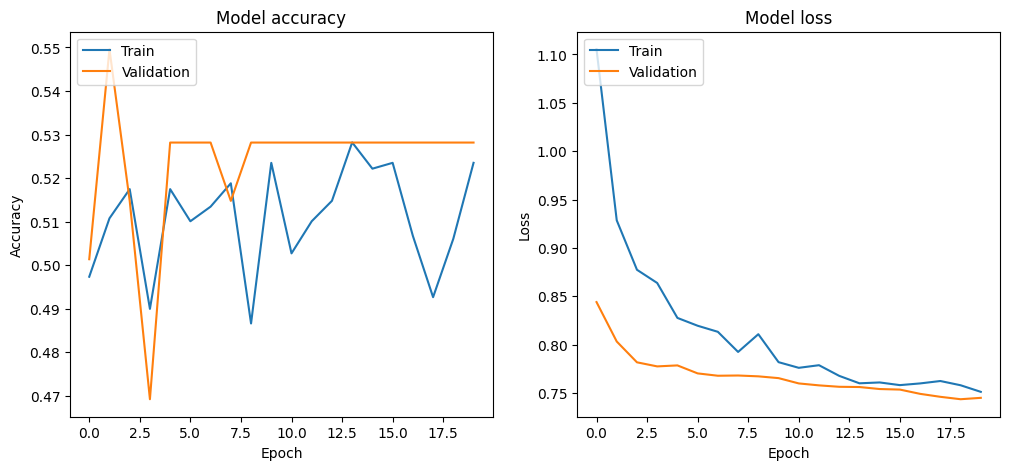

15/15 [==============================] - 0s 6ms/step - loss: 0.7433 - accuracy: 0.5451 - precision: 0.6667 - recall: 0.1880
Test Accuracy for Returns from day  2  : 54.51%
Test Precision for Returns from day  2  : 66.67%
Test Recall for Returns from day  2  : 18.80%
Test Loss for Returns from day  2  : 0.7433
Epoch 1/20
47/47 [==============================] - 12s 173ms/step - loss: 1.0498 - accuracy: 0.5228 - precision: 0.6161 - recall: 0.6115 - val_loss: 0.8710 - val_accuracy: 0.4075 - val_precision: 0.8276 - val_recall: 0.1000
Epoch 2/20
47/47 [==============================] - 4s 89ms/step - loss: 0.8859 - accuracy: 0.5658 - precision: 0.6315 - recall: 0.7197 - val_loss: 0.7366 - val_accuracy: 0.7185 - val_precision: 0.6957 - val_recall: 1.0000
Epoch 3/20
47/47 [==============================] - 3s 60ms/step - loss: 0.8269 - accuracy: 0.5792 - precision: 0.6394 - recall: 0.7370 - val_loss: 0.7263 - val_accuracy: 0.6729 - val_precision: 0.6630 - val_recall: 1.0000
Epoch 4/20
47/47 [

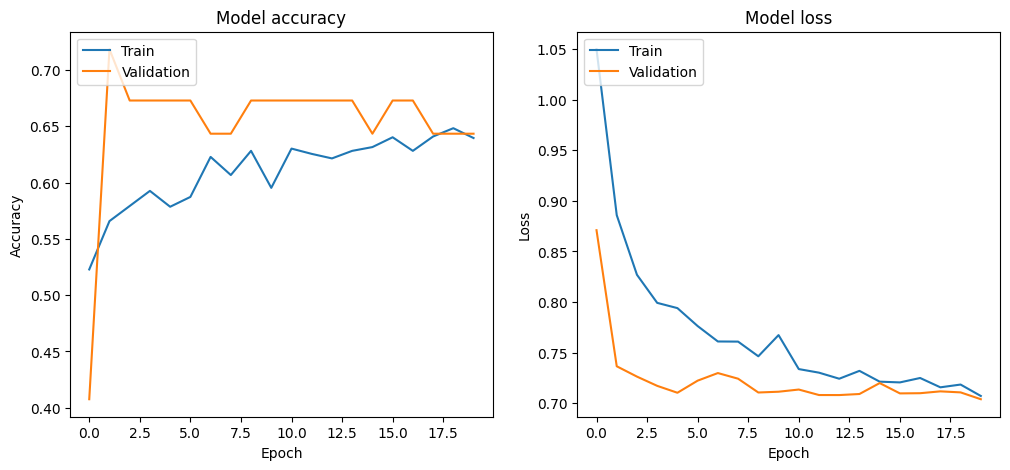

15/15 [==============================] - 0s 7ms/step - loss: 0.7073 - accuracy: 0.6330 - precision: 0.6330 - recall: 1.0000
Test Accuracy for Returns from day  3  : 63.30%
Test Precision for Returns from day  3  : 63.30%
Test Recall for Returns from day  3  : 100.00%
Test Loss for Returns from day  3  : 0.7073
Epoch 1/20
47/47 [==============================] - 13s 192ms/step - loss: 0.9584 - accuracy: 0.5752 - precision: 0.7043 - recall: 0.6835 - val_loss: 0.8719 - val_accuracy: 0.6676 - val_precision: 0.6676 - val_recall: 1.0000
Epoch 2/20
47/47 [==============================] - 3s 68ms/step - loss: 0.8707 - accuracy: 0.6215 - precision: 0.6976 - recall: 0.8160 - val_loss: 0.7571 - val_accuracy: 0.6676 - val_precision: 0.6676 - val_recall: 1.0000
Epoch 3/20
47/47 [==============================] - 3s 58ms/step - loss: 0.8002 - accuracy: 0.6349 - precision: 0.7025 - recall: 0.8351 - val_loss: 0.7370 - val_accuracy: 0.6676 - val_precision: 0.6676 - val_recall: 1.0000
Epoch 4/20
47/47 

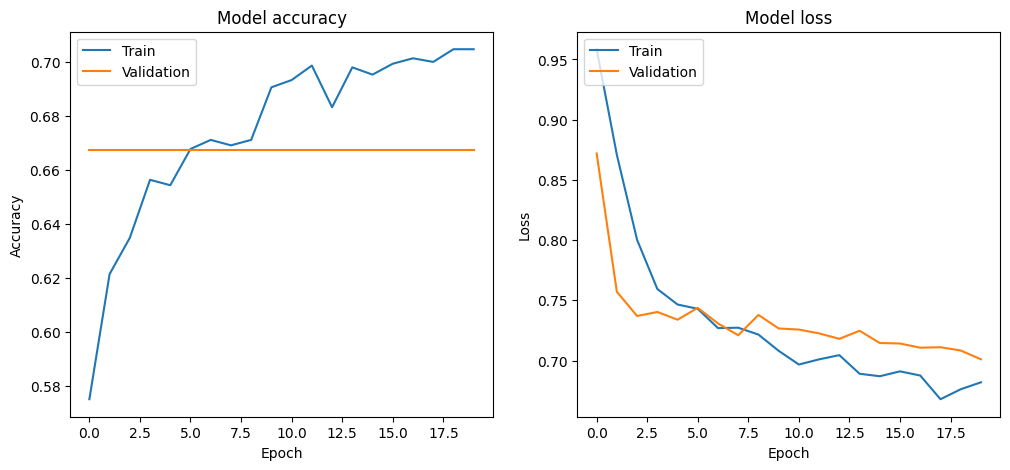

15/15 [==============================] - 0s 6ms/step - loss: 0.6898 - accuracy: 0.6867 - precision: 0.6867 - recall: 1.0000
Test Accuracy for Returns from day  4  : 68.67%
Test Precision for Returns from day  4  : 68.67%
Test Recall for Returns from day  4  : 100.00%
Test Loss for Returns from day  4  : 0.6898
Epoch 1/20
47/47 [==============================] - 12s 183ms/step - loss: 0.8779 - accuracy: 0.6604 - precision: 0.7873 - recall: 0.7792 - val_loss: 0.7251 - val_accuracy: 0.7694 - val_precision: 0.7694 - val_recall: 1.0000
Epoch 2/20
47/47 [==============================] - 4s 78ms/step - loss: 0.7315 - accuracy: 0.7450 - precision: 0.7909 - recall: 0.9190 - val_loss: 0.7027 - val_accuracy: 0.7694 - val_precision: 0.7694 - val_recall: 1.0000
Epoch 3/20
47/47 [==============================] - 3s 56ms/step - loss: 0.6948 - accuracy: 0.7570 - precision: 0.7919 - recall: 0.9378 - val_loss: 0.7033 - val_accuracy: 0.7694 - val_precision: 0.7694 - val_recall: 1.0000
Epoch 4/20
47/47 

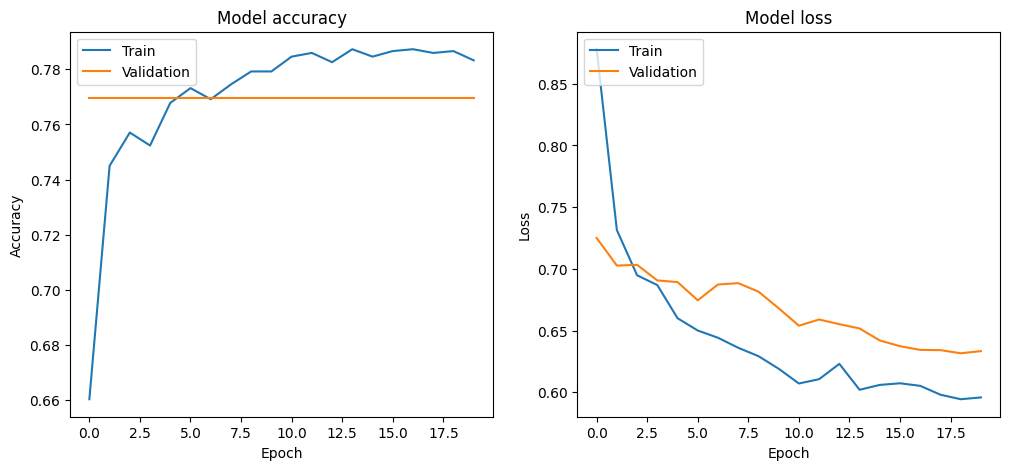

15/15 [==============================] - 0s 6ms/step - loss: 0.6168 - accuracy: 0.7918 - precision: 0.7918 - recall: 1.0000
Test Accuracy for Returns from day  5  : 79.18%
Test Precision for Returns from day  5  : 79.18%
Test Recall for Returns from day  5  : 100.00%
Test Loss for Returns from day  5  : 0.6168


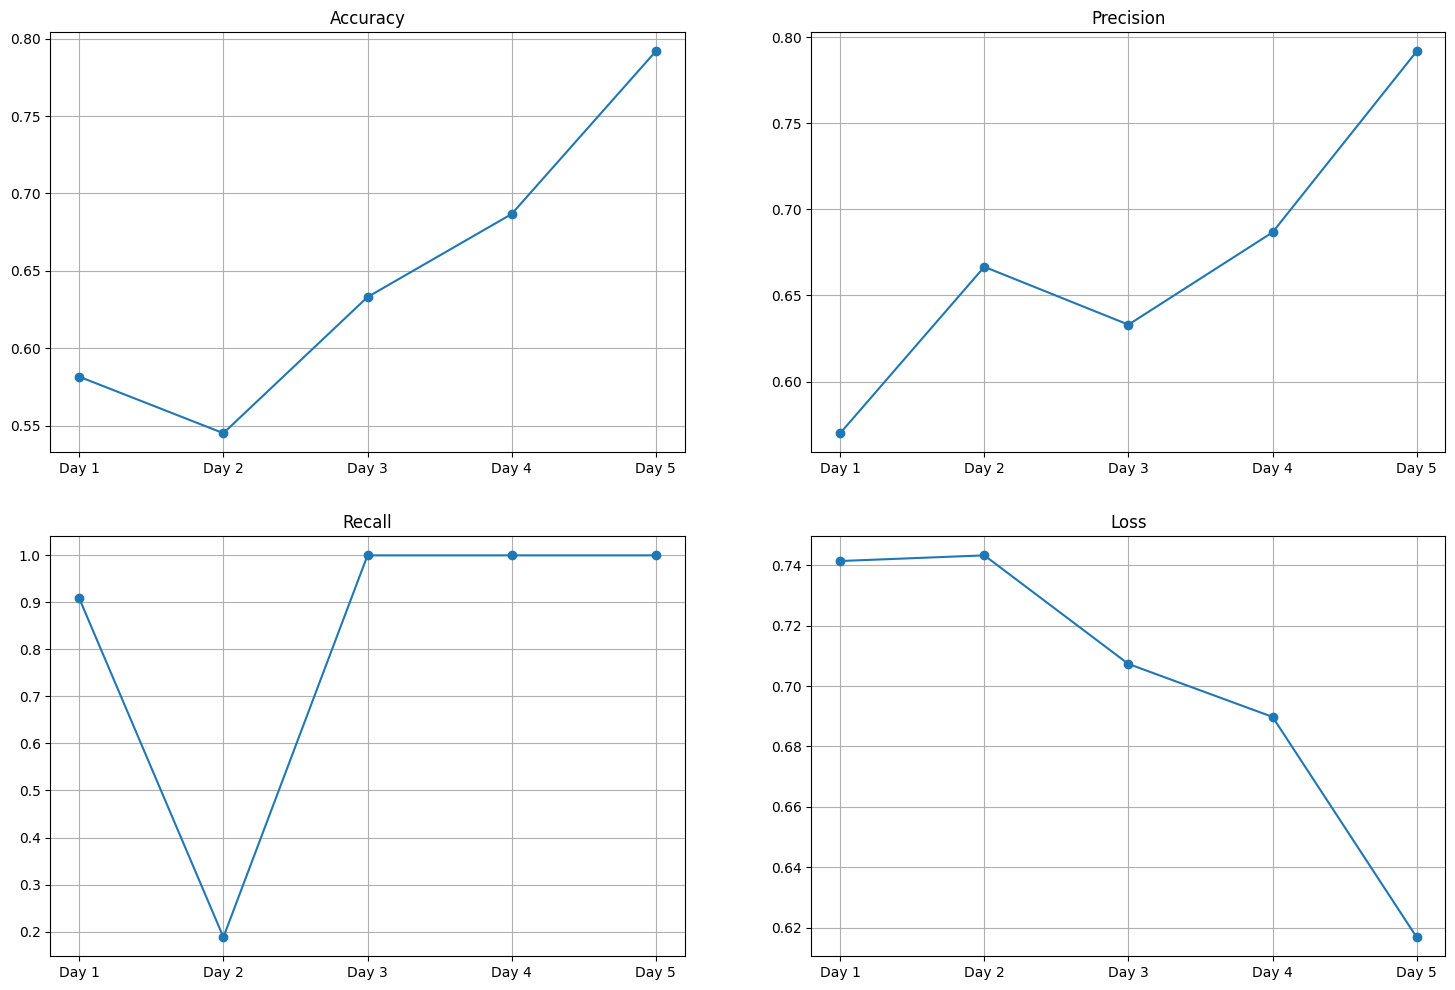

In [ ]:
print("=============  HOT FINBERT LSTM  =============== \n")
accuracy =[]
precision=[]
recall =[]
loss=[]
for i in range(1,6):
  evaluation = model_LSTM_weekly(hot_finbert,i)
  loss.append(evaluation[0])
  accuracy.append(evaluation[1])
  precision.append(evaluation[2])
  recall.append(evaluation[3])

plot_week_eval(accuracy,precision,recall,loss)

=============  NEW FINBERT LSTM  =============== 

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 34)]         0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 34, 128)      1280000     ['text_input[0][0]']             
                                                                                                  
 market_input (InputLayer)      [(None, 5)]          0           []                               
                                                                                                  
 lstm_5 (LSTM)                  (None, 128)          131584      ['embedding_5[0][0]']            
                                         

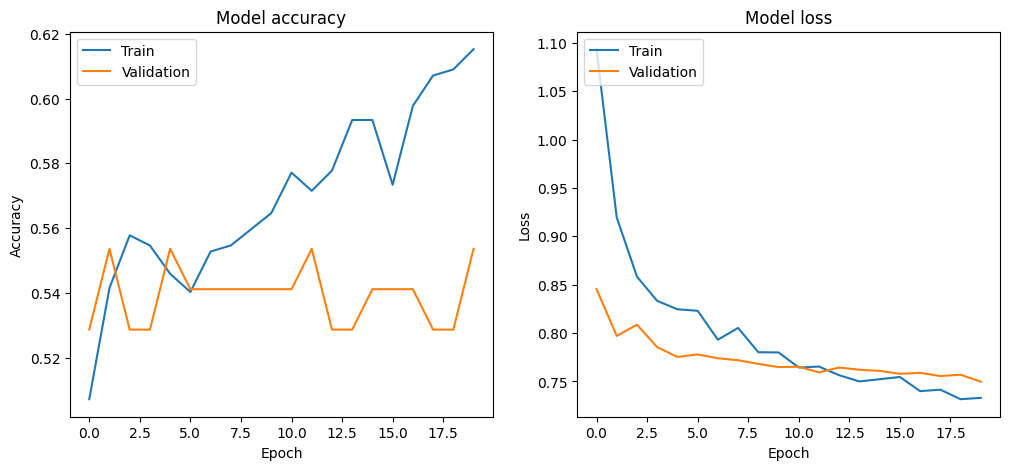

16/16 [==============================] - 0s 9ms/step - loss: 0.7405 - accuracy: 0.5828 - precision: 0.5708 - recall: 1.0000
Test Accuracy for Returns from day  1  : 58.28%
Test Precision for Returns from day  1  : 57.08%
Test Recall for Returns from day  1  : 100.00%
Test Loss for Returns from day  1  : 0.7405
Epoch 1/20
51/51 [==============================] - 14s 192ms/step - loss: 1.1249 - accuracy: 0.4891 - precision: 0.5381 - recall: 0.4977 - val_loss: 0.8614 - val_accuracy: 0.4938 - val_precision: 0.4938 - val_recall: 1.0000
Epoch 2/20
51/51 [==============================] - 3s 61ms/step - loss: 0.9288 - accuracy: 0.5265 - precision: 0.5659 - recall: 0.5955 - val_loss: 0.8152 - val_accuracy: 0.4938 - val_precision: 0.4938 - val_recall: 1.0000
Epoch 3/20
51/51 [==============================] - 3s 47ms/step - loss: 0.8791 - accuracy: 0.5278 - precision: 0.5703 - recall: 0.5716 - val_loss: 0.7858 - val_accuracy: 0.4788 - val_precision: 0.4513 - val_recall: 0.2576
Epoch 4/20
51/51 

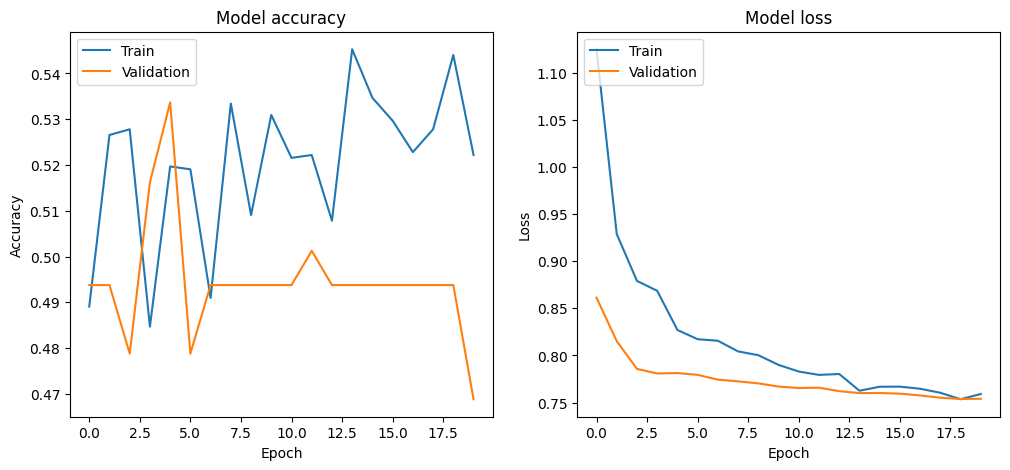

16/16 [==============================] - 0s 8ms/step - loss: 0.7529 - accuracy: 0.4790 - precision: 0.4928 - recall: 0.9449
Test Accuracy for Returns from day  2  : 47.90%
Test Precision for Returns from day  2  : 49.28%
Test Recall for Returns from day  2  : 94.49%
Test Loss for Returns from day  2  : 0.7529
Epoch 1/20
51/51 [==============================] - 12s 154ms/step - loss: 1.0033 - accuracy: 0.5465 - precision: 0.6280 - recall: 0.6950 - val_loss: 0.8118 - val_accuracy: 0.6010 - val_precision: 0.5908 - val_recall: 1.0000
Epoch 2/20
51/51 [==============================] - 4s 81ms/step - loss: 0.8521 - accuracy: 0.5809 - precision: 0.6427 - recall: 0.7601 - val_loss: 0.7715 - val_accuracy: 0.5736 - val_precision: 0.5882 - val_recall: 0.8658
Epoch 3/20
51/51 [==============================] - 3s 57ms/step - loss: 0.8124 - accuracy: 0.5840 - precision: 0.6387 - recall: 0.7887 - val_loss: 0.7552 - val_accuracy: 0.6010 - val_precision: 0.5908 - val_recall: 1.0000
Epoch 4/20
51/51 [

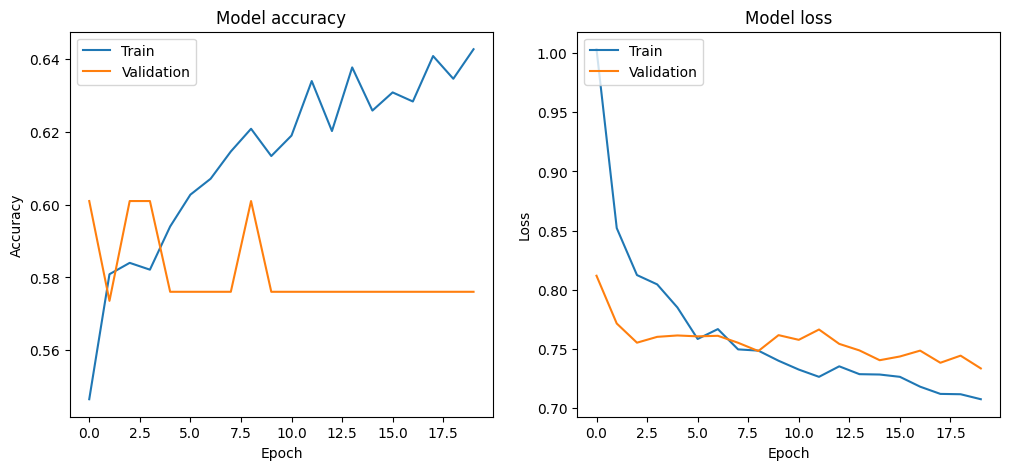

16/16 [==============================] - 0s 8ms/step - loss: 0.7190 - accuracy: 0.6088 - precision: 0.6088 - recall: 1.0000
Test Accuracy for Returns from day  3  : 60.88%
Test Precision for Returns from day  3  : 60.88%
Test Recall for Returns from day  3  : 100.00%
Test Loss for Returns from day  3  : 0.7190
Epoch 1/20
51/51 [==============================] - 13s 168ms/step - loss: 0.9309 - accuracy: 0.6352 - precision: 0.7429 - recall: 0.7767 - val_loss: 0.7609 - val_accuracy: 0.7032 - val_precision: 0.7032 - val_recall: 1.0000
Epoch 2/20
51/51 [==============================] - 3s 63ms/step - loss: 0.7959 - accuracy: 0.6871 - precision: 0.7426 - recall: 0.8846 - val_loss: 0.7386 - val_accuracy: 0.7032 - val_precision: 0.7032 - val_recall: 1.0000
Epoch 3/20
51/51 [==============================] - 3s 52ms/step - loss: 0.7405 - accuracy: 0.6952 - precision: 0.7502 - recall: 0.8829 - val_loss: 0.7554 - val_accuracy: 0.7032 - val_precision: 0.7032 - val_recall: 1.0000
Epoch 4/20
51/51 

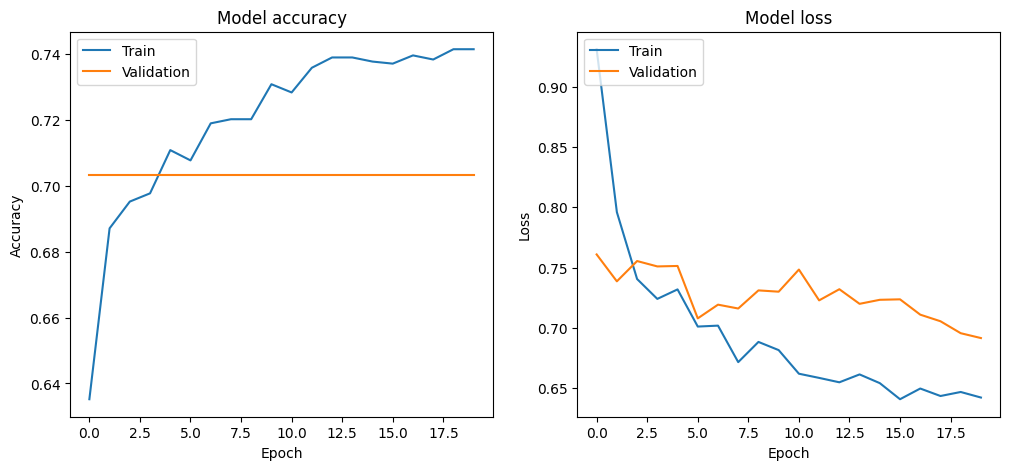

16/16 [==============================] - 0s 6ms/step - loss: 0.6886 - accuracy: 0.7066 - precision: 0.7066 - recall: 1.0000
Test Accuracy for Returns from day  4  : 70.66%
Test Precision for Returns from day  4  : 70.66%
Test Recall for Returns from day  4  : 100.00%
Test Loss for Returns from day  4  : 0.6886
Epoch 1/20
51/51 [==============================] - 13s 178ms/step - loss: 0.8034 - accuracy: 0.7220 - precision: 0.8055 - recall: 0.8636 - val_loss: 0.7238 - val_accuracy: 0.7456 - val_precision: 0.7456 - val_recall: 1.0000
Epoch 2/20
51/51 [==============================] - 4s 78ms/step - loss: 0.7016 - accuracy: 0.7751 - precision: 0.8092 - recall: 0.9434 - val_loss: 0.6928 - val_accuracy: 0.7456 - val_precision: 0.7456 - val_recall: 1.0000
Epoch 3/20
51/51 [==============================] - 3s 50ms/step - loss: 0.6677 - accuracy: 0.7764 - precision: 0.8018 - recall: 0.9597 - val_loss: 0.6888 - val_accuracy: 0.7456 - val_precision: 0.7456 - val_recall: 1.0000
Epoch 4/20
51/51 

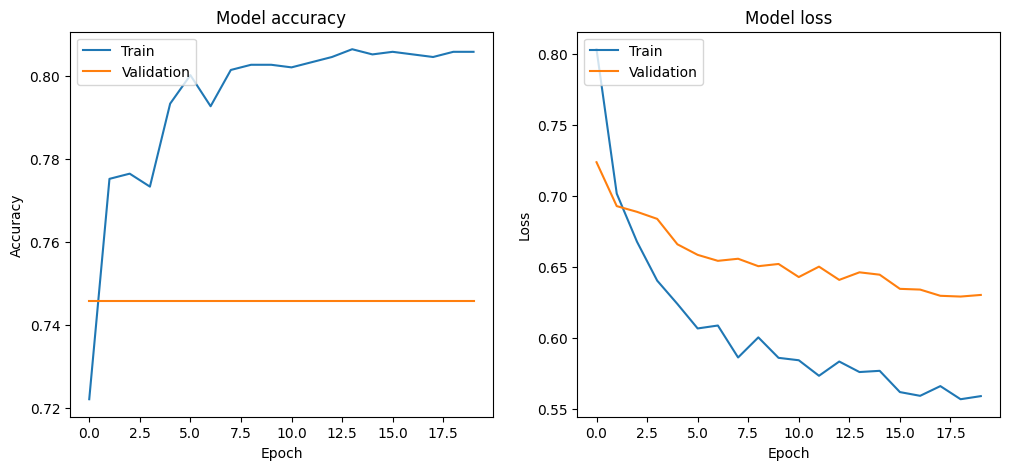

16/16 [==============================] - 0s 6ms/step - loss: 0.6076 - accuracy: 0.7725 - precision: 0.7725 - recall: 1.0000
Test Accuracy for Returns from day  5  : 77.25%
Test Precision for Returns from day  5  : 77.25%
Test Recall for Returns from day  5  : 100.00%
Test Loss for Returns from day  5  : 0.6076


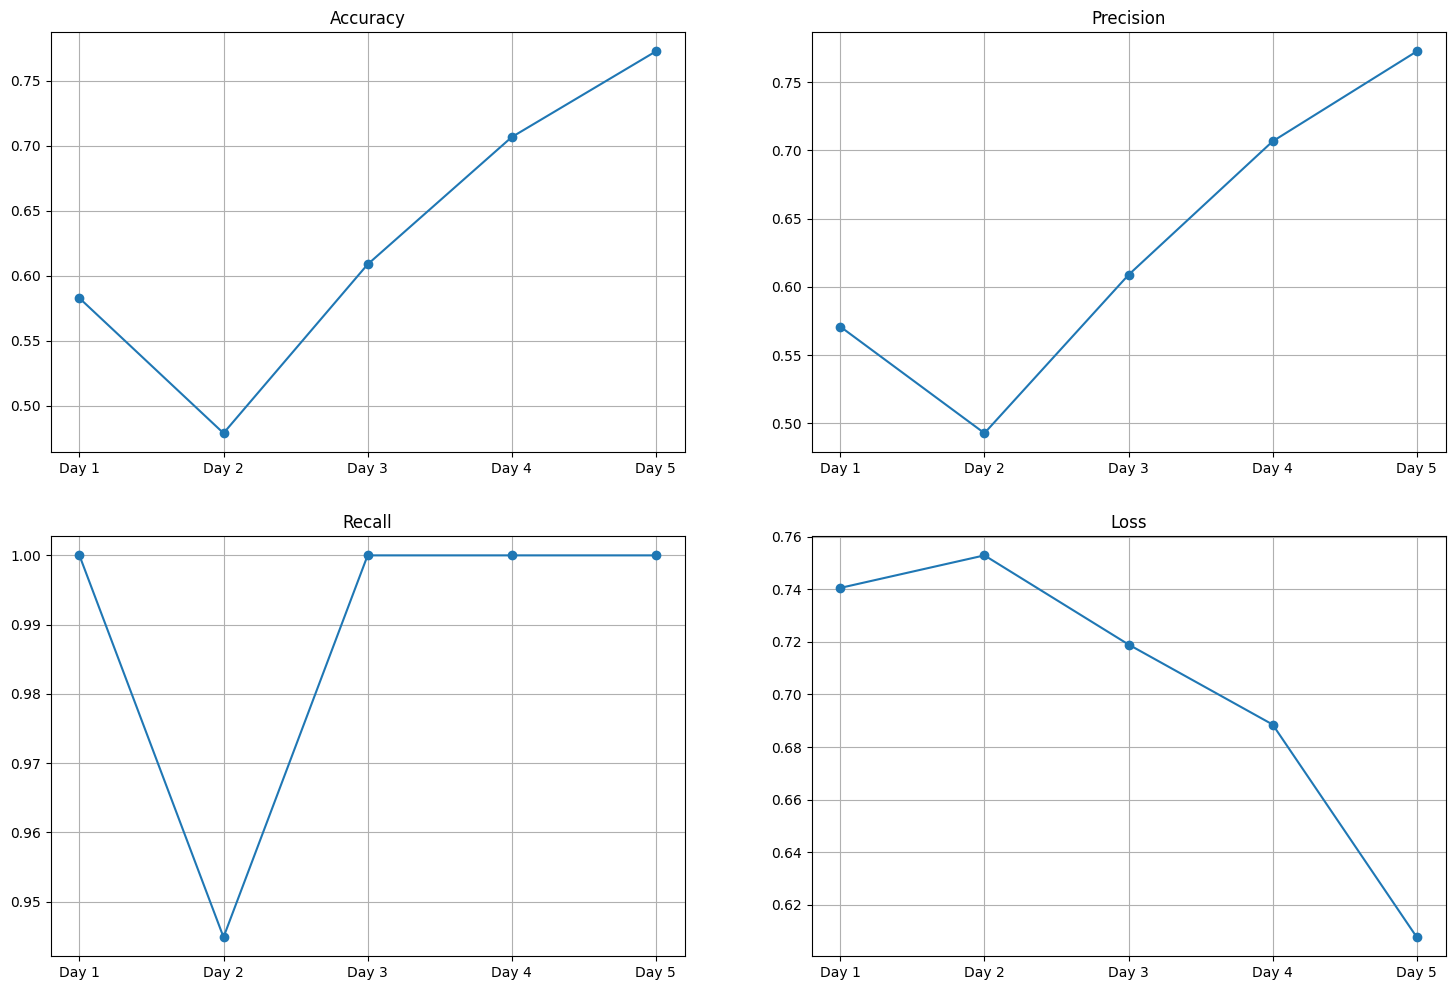

In [ ]:
print("=============  NEW FINBERT LSTM  =============== \n")
accuracy =[]
precision=[]
recall =[]
loss=[]
for i in range(1,6):
  evaluation = model_LSTM_weekly(new_finbert,i)
  loss.append(evaluation[0])
  accuracy.append(evaluation[1])
  precision.append(evaluation[2])
  recall.append(evaluation[3])

plot_week_eval(accuracy,precision,recall,loss)

=============  HOT ROBERTA LSTM  =============== 

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 32)]         0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 32, 128)      1280000     ['text_input[0][0]']             
                                                                                                  
 market_input (InputLayer)      [(None, 5)]          0           []                               
                                                                                                  
 lstm_10 (LSTM)                 (None, 128)          131584      ['embedding_10[0][0]']           
                                        

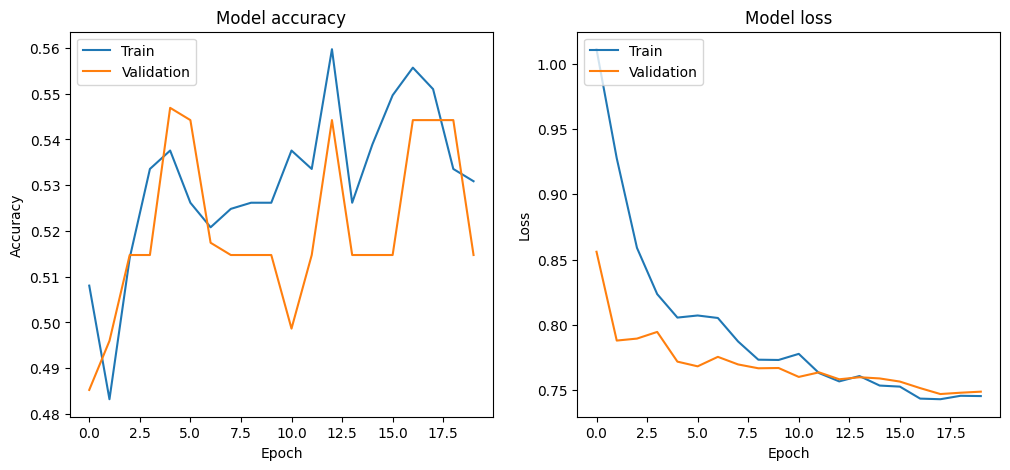

15/15 [==============================] - 0s 5ms/step - loss: 0.7448 - accuracy: 0.5451 - precision: 0.5468 - recall: 0.9084
Test Accuracy for Returns from day  1  : 54.51%
Test Precision for Returns from day  1  : 54.68%
Test Recall for Returns from day  1  : 90.84%
Test Loss for Returns from day  1  : 0.7448
Epoch 1/20
47/47 [==============================] - 12s 181ms/step - loss: 0.9953 - accuracy: 0.5181 - precision: 0.5419 - recall: 0.6332 - val_loss: 0.9106 - val_accuracy: 0.5147 - val_precision: 0.5147 - val_recall: 1.0000
Epoch 2/20
47/47 [==============================] - 3s 65ms/step - loss: 0.8728 - accuracy: 0.5168 - precision: 0.5442 - recall: 0.5879 - val_loss: 0.8009 - val_accuracy: 0.4879 - val_precision: 0.5054 - val_recall: 0.2448
Epoch 3/20
47/47 [==============================] - 2s 48ms/step - loss: 0.8633 - accuracy: 0.4987 - precision: 0.5264 - recall: 0.6143 - val_loss: 0.7855 - val_accuracy: 0.4826 - val_precision: 0.4938 - val_recall: 0.2083
Epoch 4/20
47/47 [

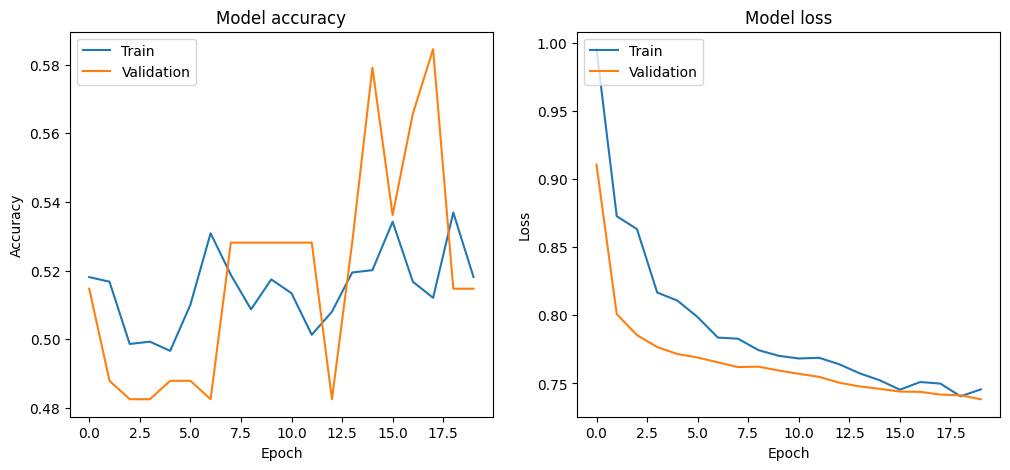

15/15 [==============================] - 0s 6ms/step - loss: 0.7368 - accuracy: 0.5021 - precision: 0.5021 - recall: 1.0000
Test Accuracy for Returns from day  2  : 50.21%
Test Precision for Returns from day  2  : 50.21%
Test Recall for Returns from day  2  : 100.00%
Test Loss for Returns from day  2  : 0.7368
Epoch 1/20
47/47 [==============================] - 12s 146ms/step - loss: 0.9986 - accuracy: 0.5671 - precision: 0.6452 - recall: 0.6710 - val_loss: 0.9587 - val_accuracy: 0.4075 - val_precision: 0.8276 - val_recall: 0.1000
Epoch 2/20
47/47 [==============================] - 3s 70ms/step - loss: 0.8765 - accuracy: 0.5651 - precision: 0.6335 - recall: 0.7089 - val_loss: 0.7442 - val_accuracy: 0.6863 - val_precision: 0.6847 - val_recall: 0.9500
Epoch 3/20
47/47 [==============================] - 4s 83ms/step - loss: 0.8534 - accuracy: 0.5597 - precision: 0.6209 - recall: 0.7446 - val_loss: 0.7184 - val_accuracy: 0.7185 - val_precision: 0.6957 - val_recall: 1.0000
Epoch 4/20
47/47 

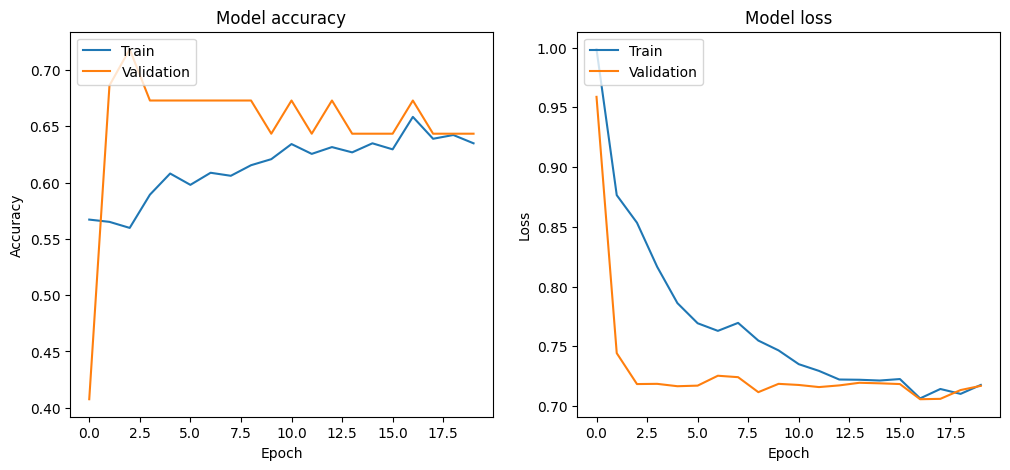

15/15 [==============================] - 0s 9ms/step - loss: 0.7180 - accuracy: 0.6330 - precision: 0.6330 - recall: 1.0000
Test Accuracy for Returns from day  3  : 63.30%
Test Precision for Returns from day  3  : 63.30%
Test Recall for Returns from day  3  : 100.00%
Test Loss for Returns from day  3  : 0.7180
Epoch 1/20
47/47 [==============================] - 11s 156ms/step - loss: 0.9631 - accuracy: 0.5758 - precision: 0.7156 - recall: 0.6597 - val_loss: 0.8569 - val_accuracy: 0.6676 - val_precision: 0.6676 - val_recall: 1.0000
Epoch 2/20
47/47 [==============================] - 5s 103ms/step - loss: 0.8337 - accuracy: 0.6362 - precision: 0.7043 - recall: 0.8332 - val_loss: 0.7466 - val_accuracy: 0.6676 - val_precision: 0.6676 - val_recall: 1.0000
Epoch 3/20
47/47 [==============================] - 2s 44ms/step - loss: 0.7720 - accuracy: 0.6503 - precision: 0.7099 - recall: 0.8513 - val_loss: 0.7389 - val_accuracy: 0.6676 - val_precision: 0.6676 - val_recall: 1.0000
Epoch 4/20
47/47

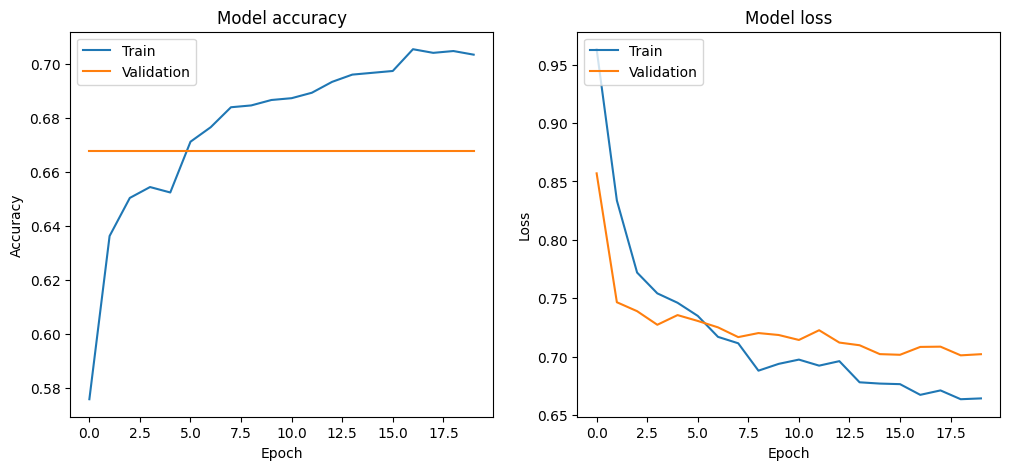

15/15 [==============================] - 0s 6ms/step - loss: 0.6950 - accuracy: 0.6867 - precision: 0.6867 - recall: 1.0000
Test Accuracy for Returns from day  4  : 68.67%
Test Precision for Returns from day  4  : 68.67%
Test Recall for Returns from day  4  : 100.00%
Test Loss for Returns from day  4  : 0.6950
Epoch 1/20
47/47 [==============================] - 13s 141ms/step - loss: 0.9038 - accuracy: 0.6564 - precision: 0.7922 - recall: 0.7639 - val_loss: 0.7157 - val_accuracy: 0.7694 - val_precision: 0.7694 - val_recall: 1.0000
Epoch 2/20
47/47 [==============================] - 5s 108ms/step - loss: 0.7794 - accuracy: 0.7289 - precision: 0.7863 - recall: 0.9003 - val_loss: 0.7050 - val_accuracy: 0.7694 - val_precision: 0.7694 - val_recall: 1.0000
Epoch 3/20
47/47 [==============================] - 3s 69ms/step - loss: 0.7127 - accuracy: 0.7329 - precision: 0.7839 - recall: 0.9122 - val_loss: 0.6937 - val_accuracy: 0.7694 - val_precision: 0.7694 - val_recall: 1.0000
Epoch 4/20
47/47

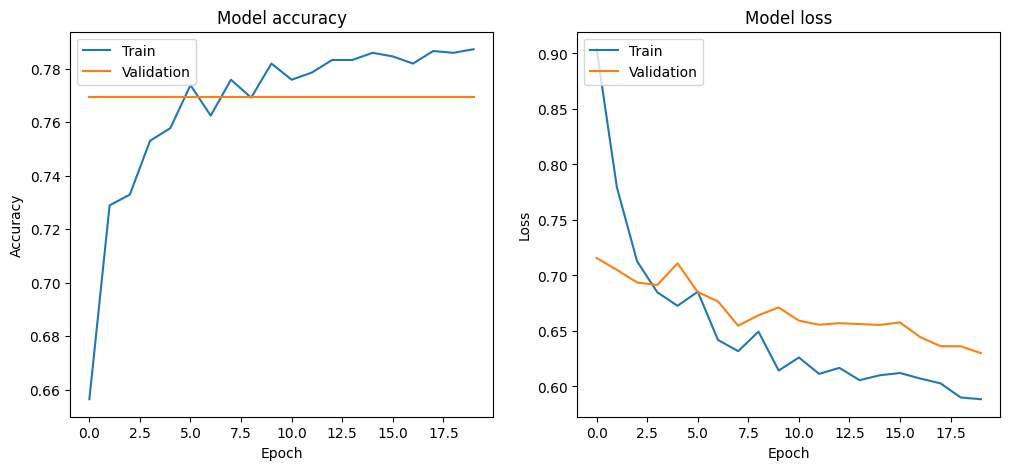

15/15 [==============================] - 0s 6ms/step - loss: 0.6129 - accuracy: 0.7918 - precision: 0.7918 - recall: 1.0000
Test Accuracy for Returns from day  5  : 79.18%
Test Precision for Returns from day  5  : 79.18%
Test Recall for Returns from day  5  : 100.00%
Test Loss for Returns from day  5  : 0.6129


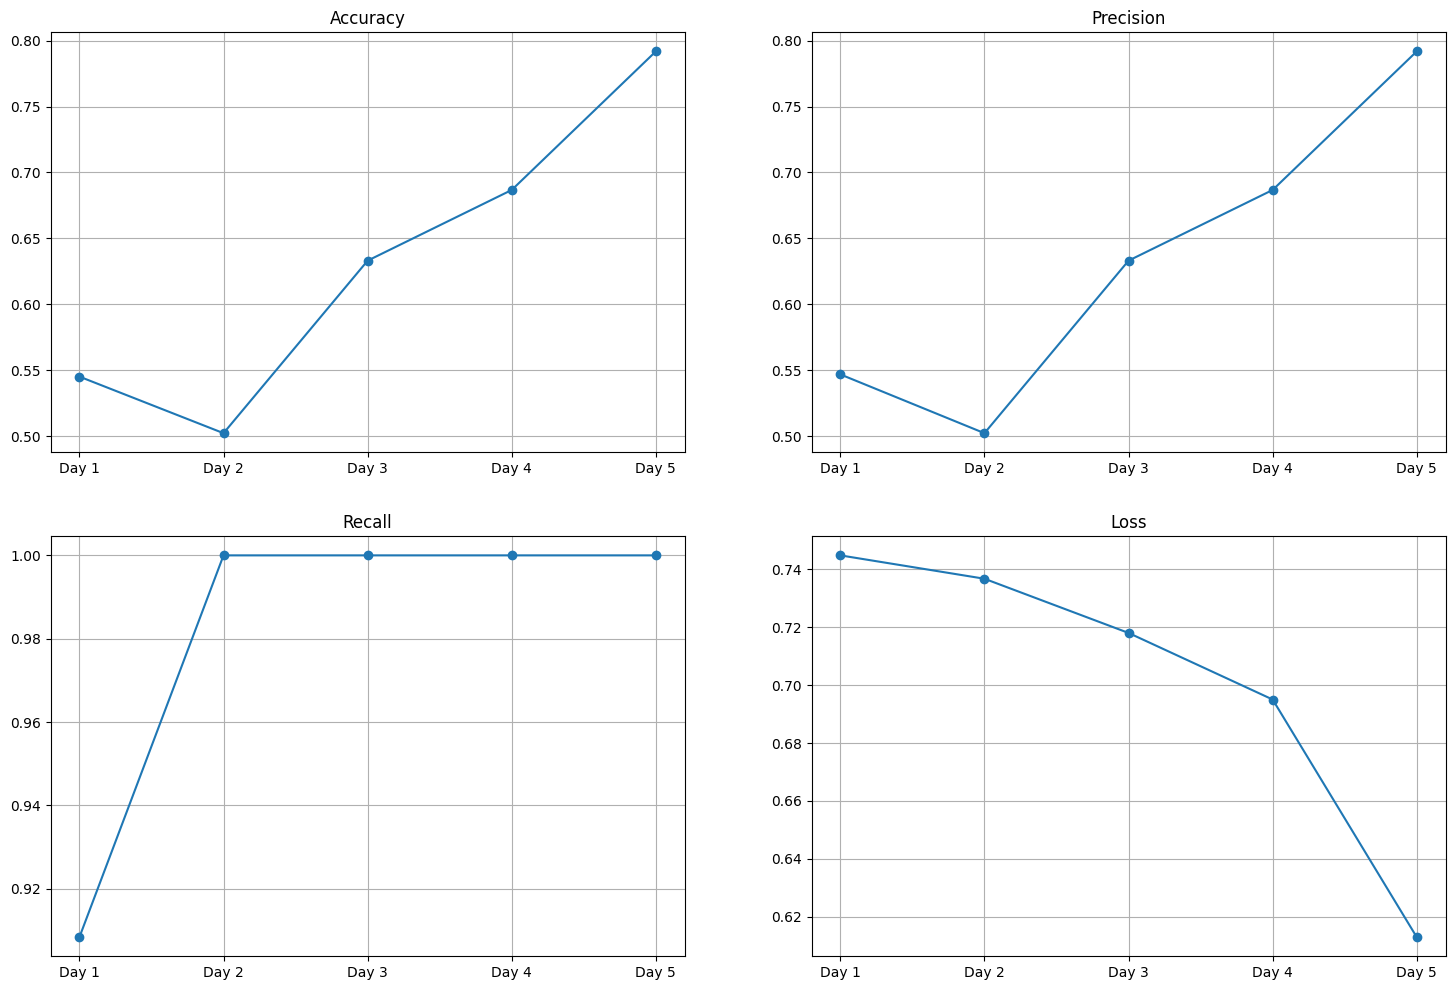

In [ ]:
print("=============  HOT ROBERTA LSTM  =============== \n")
accuracy =[]
precision=[]
recall =[]
loss=[]
for i in range(1,6):
  evaluation = model_LSTM_weekly(hot_roberta,i)
  loss.append(evaluation[0])
  accuracy.append(evaluation[1])
  precision.append(evaluation[2])
  recall.append(evaluation[3])

plot_week_eval(accuracy,precision,recall,loss)

=============  NEW ROBERTA LSTM  =============== 

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 34)]         0           []                               
                                                                                                  
 embedding_15 (Embedding)       (None, 34, 128)      1280000     ['text_input[0][0]']             
                                                                                                  
 market_input (InputLayer)      [(None, 5)]          0           []                               
                                                                                                  
 lstm_15 (LSTM)                 (None, 128)          131584      ['embedding_15[0][0]']           
                                        

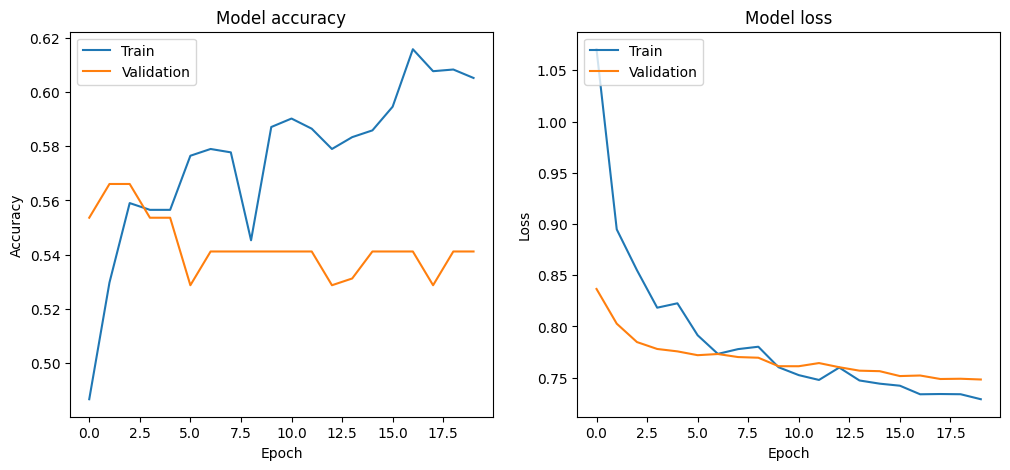

16/16 [==============================] - 0s 8ms/step - loss: 0.7418 - accuracy: 0.5609 - precision: 0.5636 - recall: 0.9245
Test Accuracy for Returns from day  1  : 56.09%
Test Precision for Returns from day  1  : 56.36%
Test Recall for Returns from day  1  : 92.45%
Test Loss for Returns from day  1  : 0.7418
Epoch 1/20
51/51 [==============================] - 12s 161ms/step - loss: 1.0576 - accuracy: 0.5309 - precision: 0.5624 - recall: 0.6602 - val_loss: 0.8375 - val_accuracy: 0.5910 - val_precision: 0.5486 - val_recall: 0.9697
Epoch 2/20
51/51 [==============================] - 6s 110ms/step - loss: 0.9344 - accuracy: 0.5009 - precision: 0.5443 - recall: 0.5659 - val_loss: 0.8116 - val_accuracy: 0.4913 - val_precision: 0.4919 - val_recall: 0.9192
Epoch 3/20
51/51 [==============================] - 2s 39ms/step - loss: 0.8916 - accuracy: 0.5134 - precision: 0.5532 - recall: 0.5966 - val_loss: 0.7977 - val_accuracy: 0.4938 - val_precision: 0.4938 - val_recall: 1.0000
Epoch 4/20
51/51 

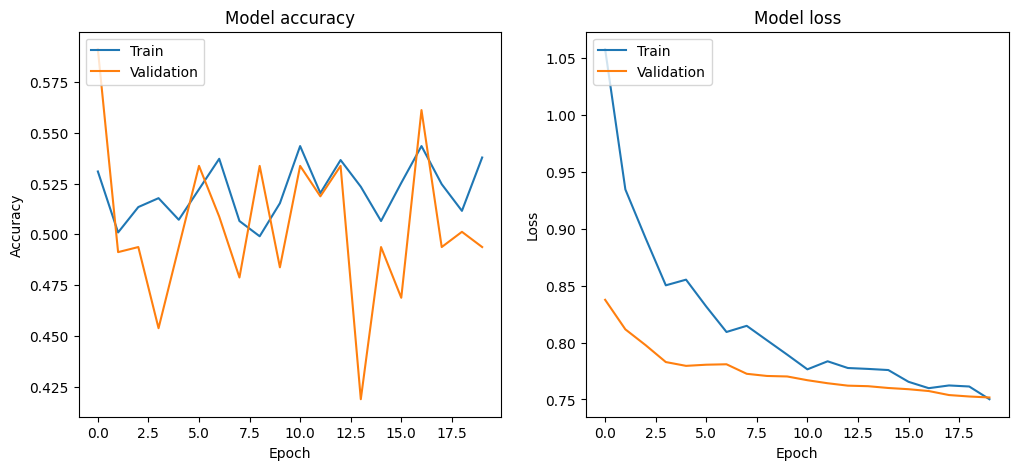

16/16 [==============================] - 0s 5ms/step - loss: 0.7505 - accuracy: 0.5070 - precision: 0.5070 - recall: 1.0000
Test Accuracy for Returns from day  2  : 50.70%
Test Precision for Returns from day  2  : 50.70%
Test Recall for Returns from day  2  : 100.00%
Test Loss for Returns from day  2  : 0.7505
Epoch 1/20
51/51 [==============================] - 12s 173ms/step - loss: 1.0269 - accuracy: 0.5509 - precision: 0.6317 - recall: 0.6960 - val_loss: 0.8221 - val_accuracy: 0.5761 - val_precision: 0.5761 - val_recall: 1.0000
Epoch 2/20
51/51 [==============================] - 3s 69ms/step - loss: 0.8962 - accuracy: 0.5665 - precision: 0.6355 - recall: 0.7384 - val_loss: 0.7697 - val_accuracy: 0.6010 - val_precision: 0.5908 - val_recall: 1.0000
Epoch 3/20
51/51 [==============================] - 2s 48ms/step - loss: 0.8356 - accuracy: 0.5859 - precision: 0.6427 - recall: 0.7779 - val_loss: 0.7659 - val_accuracy: 0.6010 - val_precision: 0.5908 - val_recall: 1.0000
Epoch 4/20
51/51 

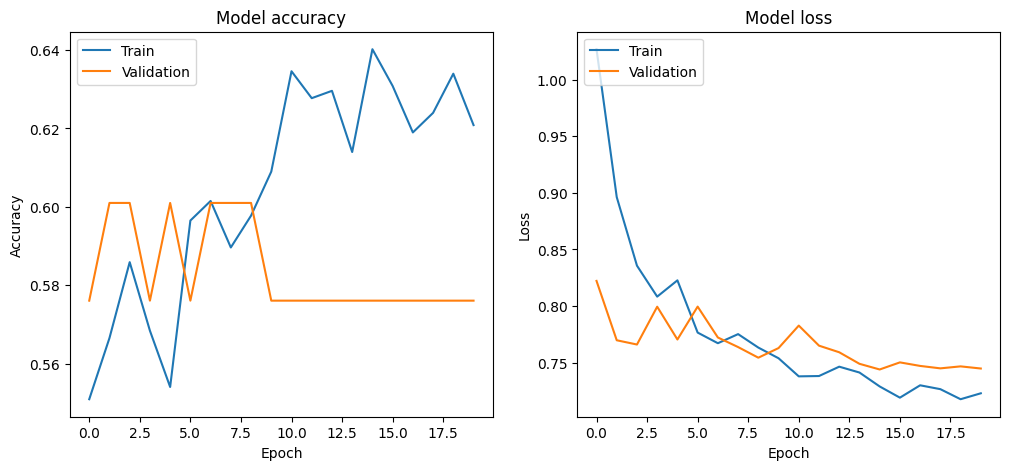

16/16 [==============================] - 0s 5ms/step - loss: 0.7297 - accuracy: 0.6088 - precision: 0.6088 - recall: 1.0000
Test Accuracy for Returns from day  3  : 60.88%
Test Precision for Returns from day  3  : 60.88%
Test Recall for Returns from day  3  : 100.00%
Test Loss for Returns from day  3  : 0.7297
Epoch 1/20
51/51 [==============================] - 12s 160ms/step - loss: 1.0149 - accuracy: 0.5653 - precision: 0.7518 - recall: 0.6175 - val_loss: 0.7659 - val_accuracy: 0.7032 - val_precision: 0.7032 - val_recall: 1.0000
Epoch 2/20
51/51 [==============================] - 4s 85ms/step - loss: 0.7867 - accuracy: 0.6839 - precision: 0.7451 - recall: 0.8719 - val_loss: 0.7290 - val_accuracy: 0.7032 - val_precision: 0.7032 - val_recall: 1.0000
Epoch 3/20
51/51 [==============================] - 2s 37ms/step - loss: 0.7603 - accuracy: 0.6896 - precision: 0.7419 - recall: 0.8913 - val_loss: 0.7078 - val_accuracy: 0.7032 - val_precision: 0.7032 - val_recall: 1.0000
Epoch 4/20
51/51 

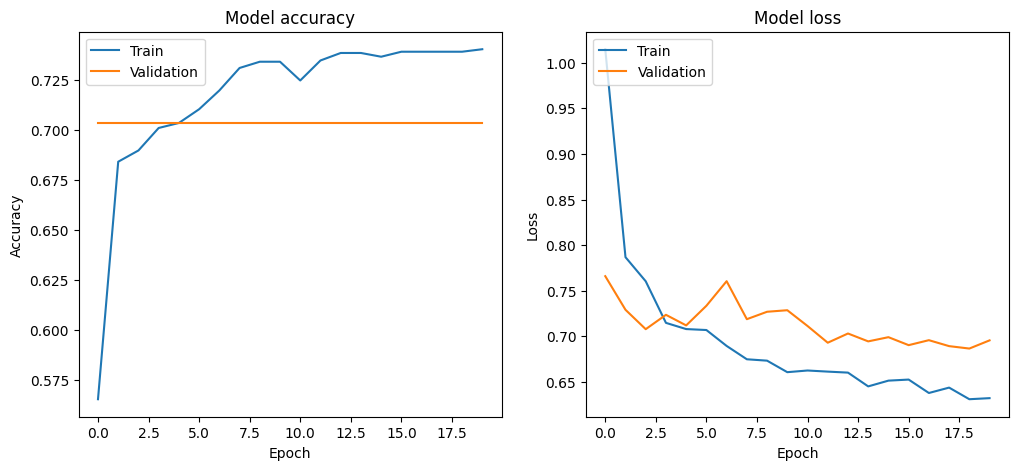

16/16 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.7066 - precision: 0.7066 - recall: 1.0000
Test Accuracy for Returns from day  4  : 70.66%
Test Precision for Returns from day  4  : 70.66%
Test Recall for Returns from day  4  : 100.00%
Test Loss for Returns from day  4  : 0.6932
Epoch 1/20
51/51 [==============================] - 13s 182ms/step - loss: 0.8458 - accuracy: 0.6933 - precision: 0.8061 - recall: 0.8155 - val_loss: 0.7471 - val_accuracy: 0.7456 - val_precision: 0.7456 - val_recall: 1.0000
Epoch 2/20
51/51 [==============================] - 4s 77ms/step - loss: 0.7439 - accuracy: 0.7545 - precision: 0.8049 - recall: 0.9178 - val_loss: 0.6795 - val_accuracy: 0.7456 - val_precision: 0.7456 - val_recall: 1.0000
Epoch 3/20
51/51 [==============================] - 2s 40ms/step - loss: 0.6749 - accuracy: 0.7708 - precision: 0.8062 - recall: 0.9419 - val_loss: 0.6701 - val_accuracy: 0.7456 - val_precision: 0.7456 - val_recall: 1.0000
Epoch 4/20
51/51 

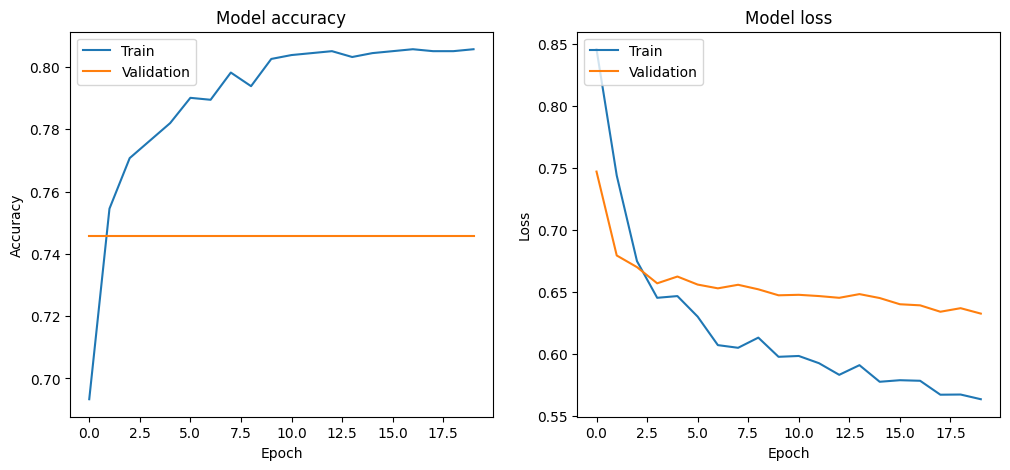

16/16 [==============================] - 0s 6ms/step - loss: 0.6035 - accuracy: 0.7725 - precision: 0.7725 - recall: 1.0000
Test Accuracy for Returns from day  5  : 77.25%
Test Precision for Returns from day  5  : 77.25%
Test Recall for Returns from day  5  : 100.00%
Test Loss for Returns from day  5  : 0.6035


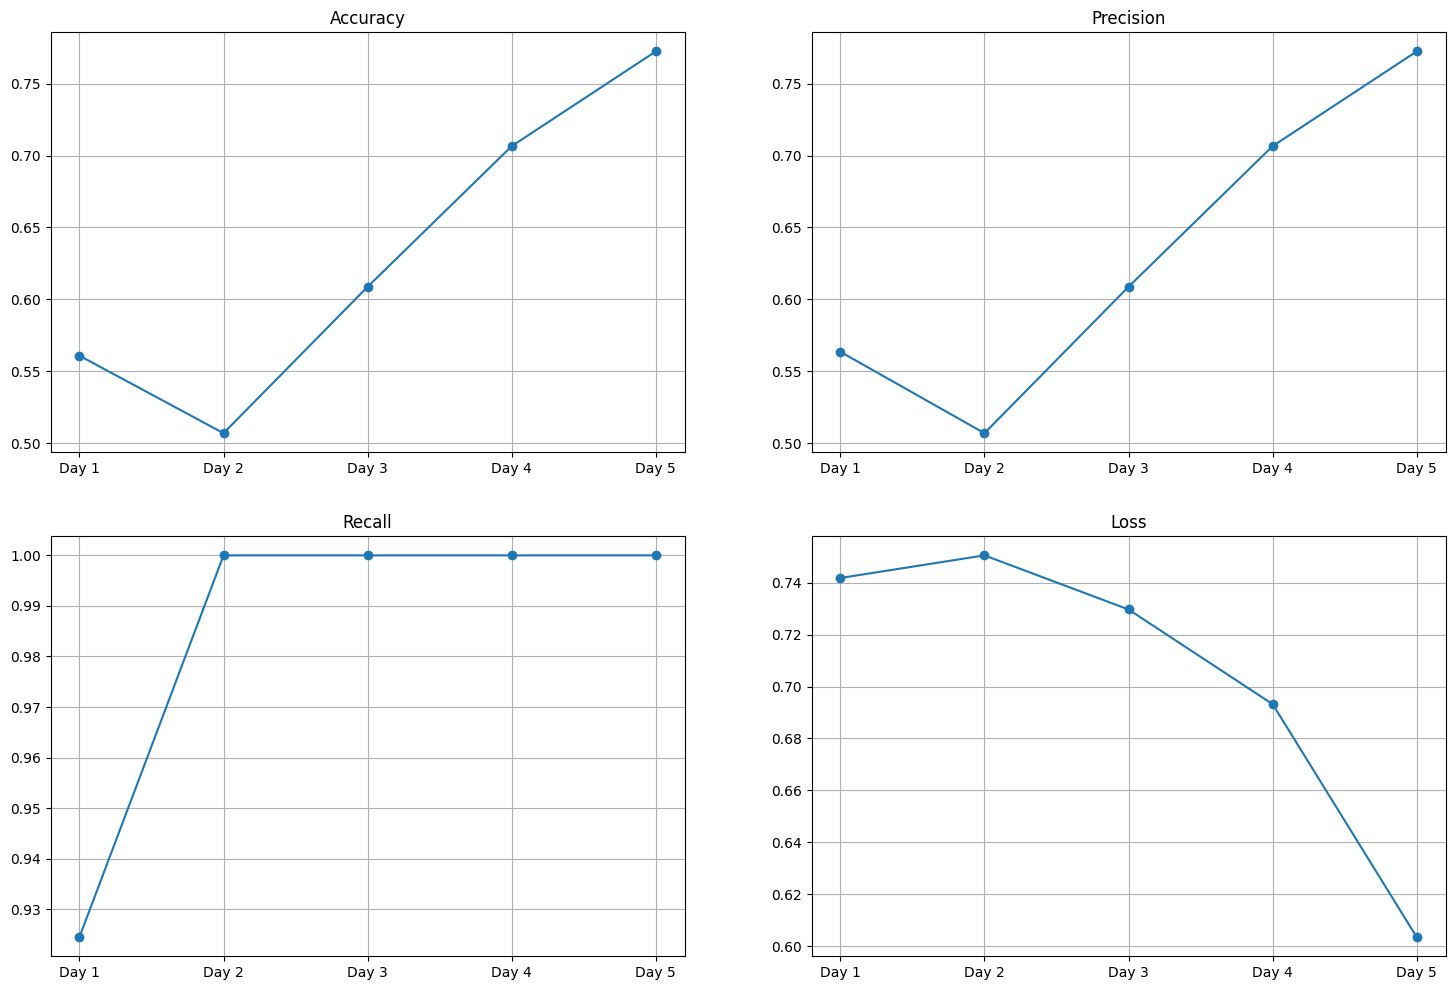

In [ ]:
print("=============  NEW ROBERTA LSTM  =============== \n")
accuracy =[]
precision=[]
recall =[]
loss=[]
for i in range(1,6):
  evaluation = model_LSTM_weekly(new_roberta,i)
  loss.append(evaluation[0])
  accuracy.append(evaluation[1])
  precision.append(evaluation[2])
  recall.append(evaluation[3])

plot_week_eval(accuracy,precision,recall,loss)

=============  HOT GPT-3 LSTM  =============== 

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 32)]         0           []                               
                                                                                                  
 embedding_20 (Embedding)       (None, 32, 128)      1280000     ['text_input[0][0]']             
                                                                                                  
 market_input (InputLayer)      [(None, 5)]          0           []                               
                                                                                                  
 lstm_20 (LSTM)                 (None, 128)          131584      ['embedding_20[0][0]']           
                                          

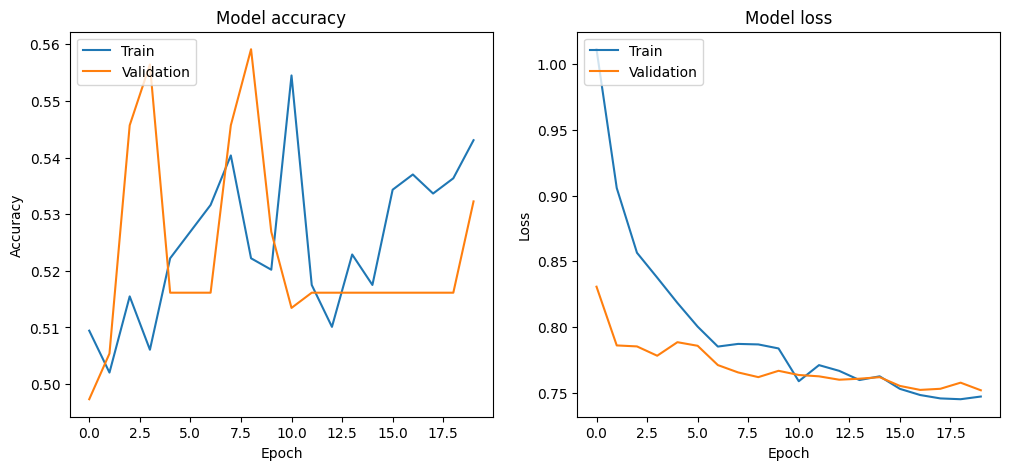

15/15 [==============================] - 0s 5ms/step - loss: 0.7473 - accuracy: 0.5333 - precision: 0.5306 - recall: 0.9918
Test Accuracy for Returns from day  1  : 53.33%
Test Precision for Returns from day  1  : 53.06%
Test Recall for Returns from day  1  : 99.18%
Test Loss for Returns from day  1  : 0.7473
Epoch 1/20
47/47 [==============================] - 12s 177ms/step - loss: 1.0688 - accuracy: 0.5215 - precision: 0.5449 - recall: 0.6550 - val_loss: 0.8422 - val_accuracy: 0.5430 - val_precision: 0.5331 - val_recall: 0.8474
Epoch 2/20
47/47 [==============================] - 4s 76ms/step - loss: 0.9141 - accuracy: 0.5209 - precision: 0.5487 - recall: 0.6010 - val_loss: 0.8065 - val_accuracy: 0.5511 - val_precision: 0.7447 - val_recall: 0.1842
Epoch 3/20
47/47 [==============================] - 2s 48ms/step - loss: 0.8333 - accuracy: 0.5491 - precision: 0.5743 - recall: 0.6161 - val_loss: 0.7871 - val_accuracy: 0.5511 - val_precision: 0.7447 - val_recall: 0.1842
Epoch 4/20
47/47 [

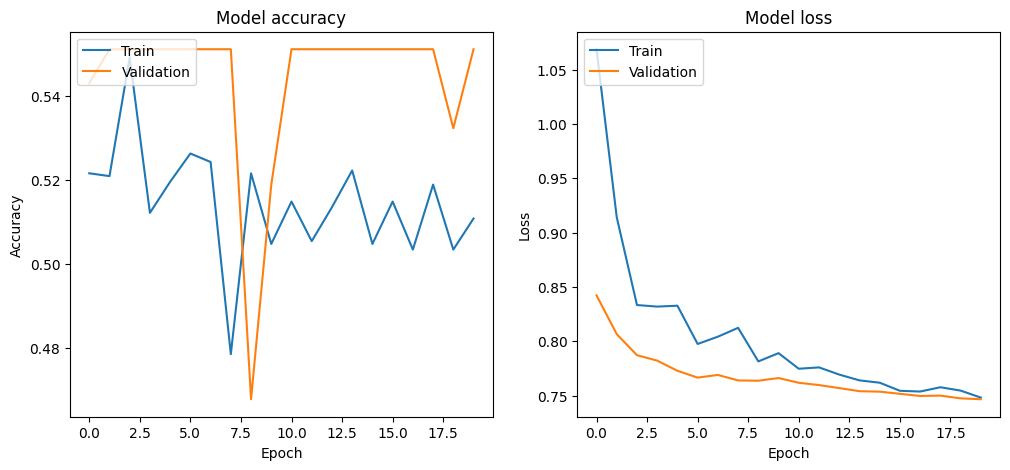

15/15 [==============================] - 0s 5ms/step - loss: 0.7465 - accuracy: 0.5419 - precision: 0.6324 - recall: 0.1861
Test Accuracy for Returns from day  2  : 54.19%
Test Precision for Returns from day  2  : 63.24%
Test Recall for Returns from day  2  : 18.61%
Test Loss for Returns from day  2  : 0.7465
Epoch 1/20
47/47 [==============================] - 11s 154ms/step - loss: 0.9917 - accuracy: 0.5545 - precision: 0.6275 - recall: 0.7033 - val_loss: 0.8516 - val_accuracy: 0.4086 - val_precision: 0.7222 - val_recall: 0.1102
Epoch 2/20
47/47 [==============================] - 5s 98ms/step - loss: 0.8689 - accuracy: 0.5686 - precision: 0.6354 - recall: 0.7238 - val_loss: 0.7566 - val_accuracy: 0.6344 - val_precision: 0.6344 - val_recall: 1.0000
Epoch 3/20
47/47 [==============================] - 3s 54ms/step - loss: 0.8068 - accuracy: 0.5942 - precision: 0.6409 - recall: 0.7950 - val_loss: 0.7388 - val_accuracy: 0.6640 - val_precision: 0.6537 - val_recall: 1.0000
Epoch 4/20
47/47 [

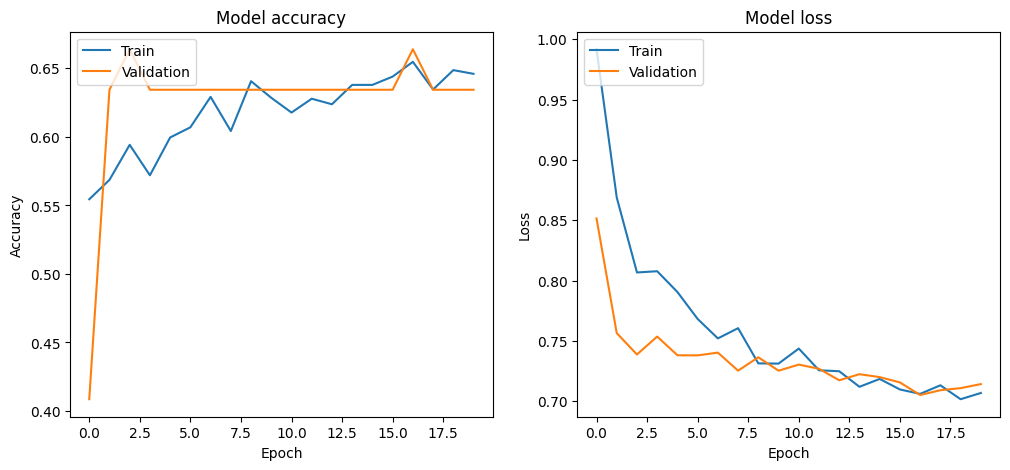

15/15 [==============================] - 0s 5ms/step - loss: 0.7137 - accuracy: 0.6280 - precision: 0.6280 - recall: 1.0000
Test Accuracy for Returns from day  3  : 62.80%
Test Precision for Returns from day  3  : 62.80%
Test Recall for Returns from day  3  : 100.00%
Test Loss for Returns from day  3  : 0.7137
Epoch 1/20
47/47 [==============================] - 12s 165ms/step - loss: 0.9475 - accuracy: 0.5882 - precision: 0.6959 - recall: 0.7410 - val_loss: 0.8365 - val_accuracy: 0.6720 - val_precision: 0.6720 - val_recall: 1.0000
Epoch 2/20
47/47 [==============================] - 4s 86ms/step - loss: 0.8623 - accuracy: 0.6151 - precision: 0.6988 - recall: 0.8000 - val_loss: 0.7561 - val_accuracy: 0.6720 - val_precision: 0.6720 - val_recall: 1.0000
Epoch 3/20
47/47 [==============================] - 3s 55ms/step - loss: 0.7942 - accuracy: 0.6433 - precision: 0.7044 - recall: 0.8533 - val_loss: 0.7513 - val_accuracy: 0.6720 - val_precision: 0.6720 - val_recall: 1.0000
Epoch 4/20
47/47 

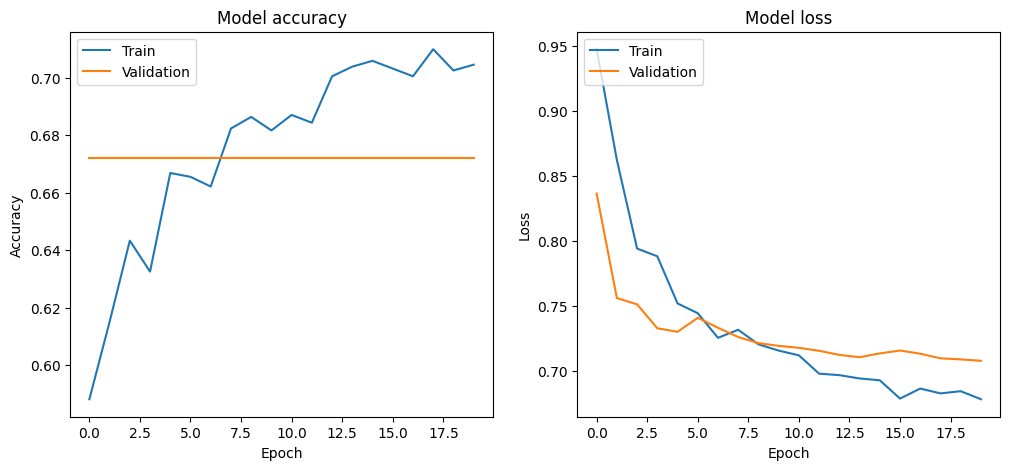

15/15 [==============================] - 0s 6ms/step - loss: 0.7056 - accuracy: 0.6753 - precision: 0.6753 - recall: 1.0000
Test Accuracy for Returns from day  4  : 67.53%
Test Precision for Returns from day  4  : 67.53%
Test Recall for Returns from day  4  : 100.00%
Test Loss for Returns from day  4  : 0.7056
Epoch 1/20
47/47 [==============================] - 12s 164ms/step - loss: 0.8495 - accuracy: 0.6878 - precision: 0.7843 - recall: 0.8350 - val_loss: 0.7312 - val_accuracy: 0.7715 - val_precision: 0.7715 - val_recall: 1.0000
Epoch 2/20
47/47 [==============================] - 4s 76ms/step - loss: 0.7149 - accuracy: 0.7577 - precision: 0.7918 - recall: 0.9413 - val_loss: 0.6614 - val_accuracy: 0.7715 - val_precision: 0.7715 - val_recall: 1.0000
Epoch 3/20
47/47 [==============================] - 4s 77ms/step - loss: 0.6696 - accuracy: 0.7550 - precision: 0.7934 - recall: 0.9337 - val_loss: 0.6741 - val_accuracy: 0.7715 - val_precision: 0.7715 - val_recall: 1.0000
Epoch 4/20
47/47 

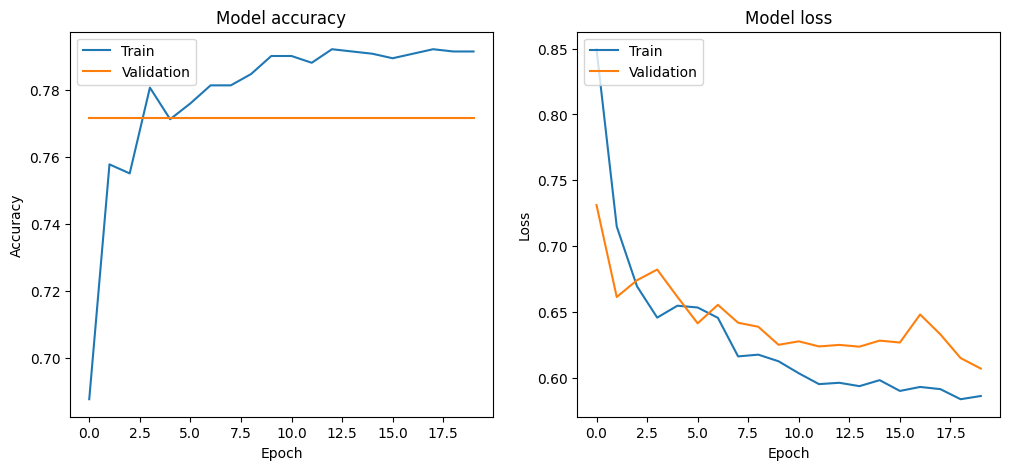

15/15 [==============================] - 0s 6ms/step - loss: 0.5924 - accuracy: 0.7785 - precision: 0.7785 - recall: 1.0000
Test Accuracy for Returns from day  5  : 77.85%
Test Precision for Returns from day  5  : 77.85%
Test Recall for Returns from day  5  : 100.00%
Test Loss for Returns from day  5  : 0.5924


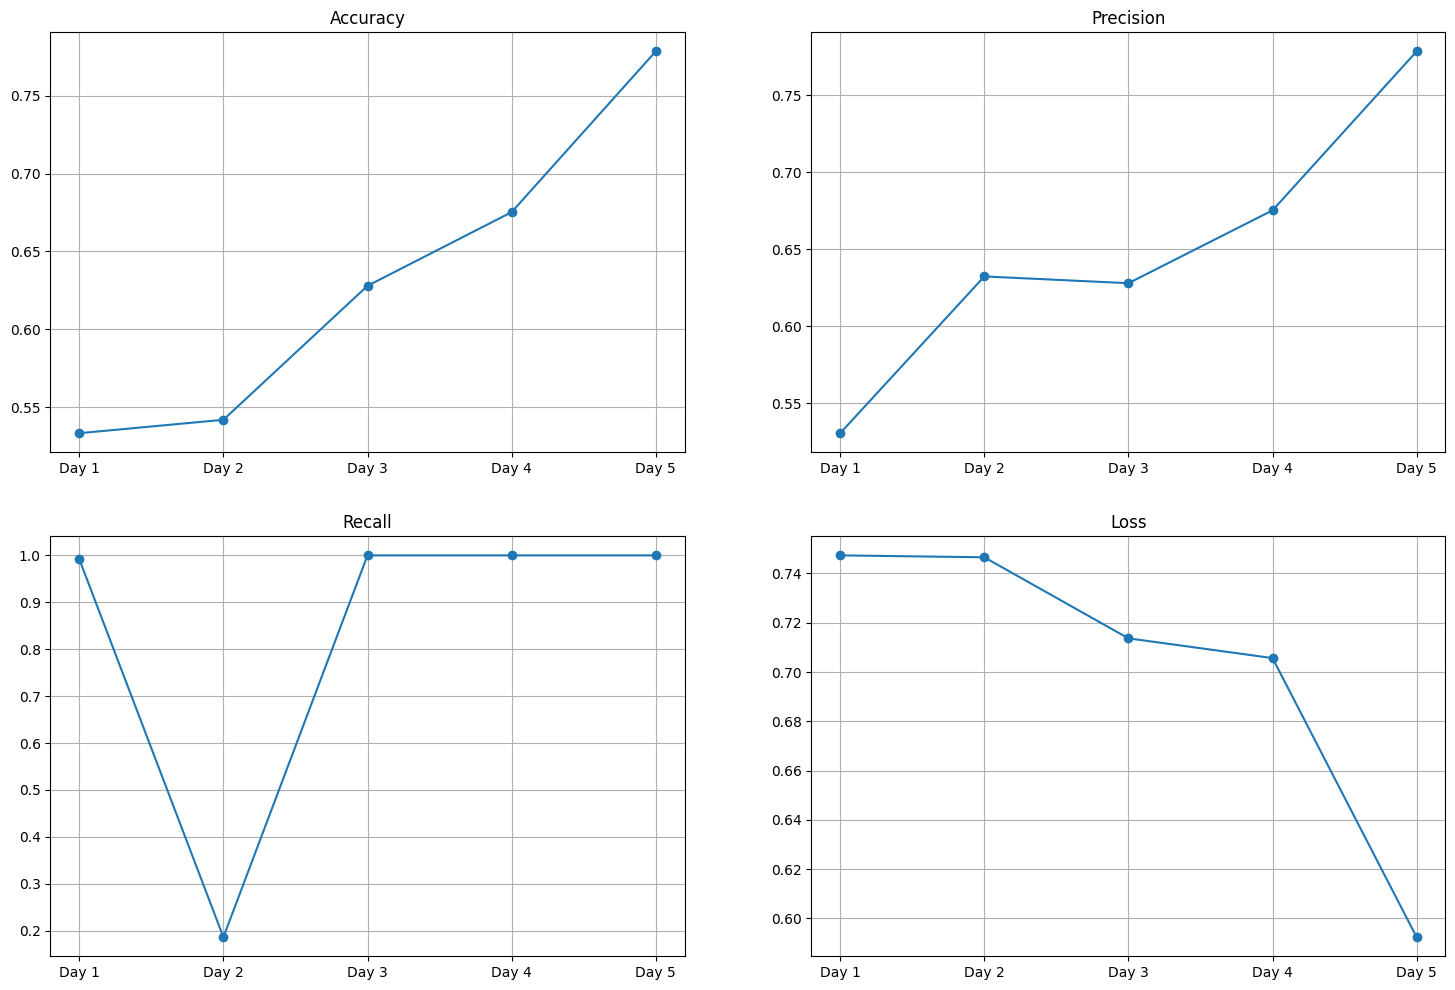

In [ ]:
print("=============  HOT GPT-3 LSTM  =============== \n")
accuracy =[]
precision=[]
recall =[]
loss=[]
for i in range(1,6):
  evaluation = model_LSTM_weekly(hot_chatgpt,i)
  loss.append(evaluation[0])
  accuracy.append(evaluation[1])
  precision.append(evaluation[2])
  recall.append(evaluation[3])

plot_week_eval(accuracy,precision,recall,loss)

=============  NEW GPT-3 LSTM  =============== 

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 34)]         0           []                               
                                                                                                  
 embedding_25 (Embedding)       (None, 34, 128)      1280000     ['text_input[0][0]']             
                                                                                                  
 market_input (InputLayer)      [(None, 5)]          0           []                               
                                                                                                  
 lstm_25 (LSTM)                 (None, 128)          131584      ['embedding_25[0][0]']           
                                          

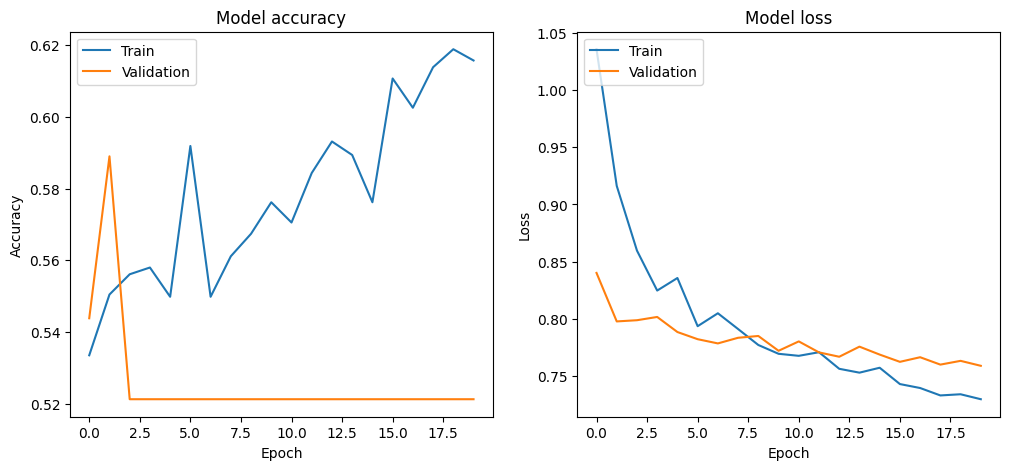

16/16 [==============================] - 0s 6ms/step - loss: 0.7457 - accuracy: 0.5551 - precision: 0.5551 - recall: 1.0000
Test Accuracy for Returns from day  1  : 55.51%
Test Precision for Returns from day  1  : 55.51%
Test Recall for Returns from day  1  : 100.00%
Test Loss for Returns from day  1  : 0.7457
Epoch 1/20
50/50 [==============================] - 13s 183ms/step - loss: 1.0460 - accuracy: 0.5147 - precision: 0.5534 - recall: 0.6089 - val_loss: 0.8338 - val_accuracy: 0.4912 - val_precision: 0.4819 - val_recall: 0.4061
Epoch 2/20
50/50 [==============================] - 3s 68ms/step - loss: 0.9671 - accuracy: 0.4978 - precision: 0.5409 - recall: 0.5735 - val_loss: 0.8066 - val_accuracy: 0.4937 - val_precision: 0.4937 - val_recall: 1.0000
Epoch 3/20
50/50 [==============================] - 3s 58ms/step - loss: 0.8958 - accuracy: 0.5091 - precision: 0.5485 - recall: 0.6066 - val_loss: 0.7972 - val_accuracy: 0.4937 - val_precision: 0.4937 - val_recall: 1.0000
Epoch 4/20
50/50 

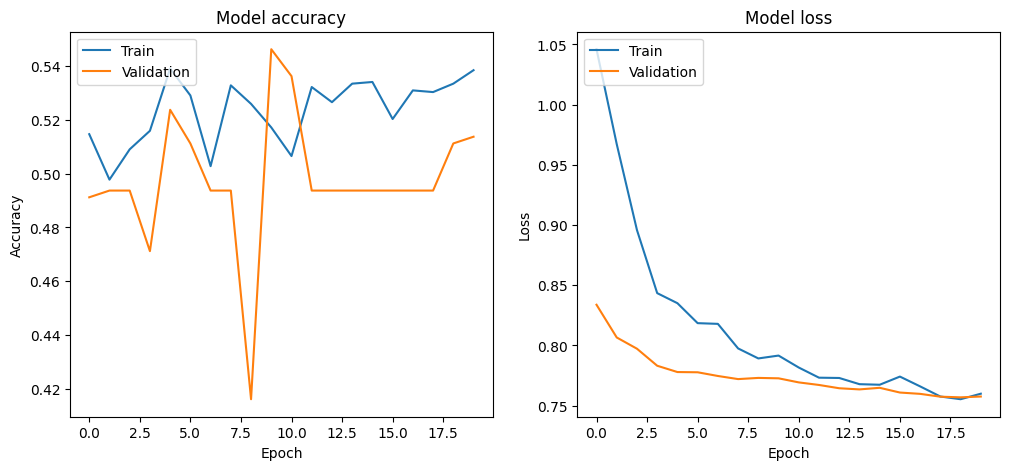

16/16 [==============================] - 0s 5ms/step - loss: 0.7563 - accuracy: 0.5391 - precision: 0.5288 - recall: 0.8016
Test Accuracy for Returns from day  2  : 53.91%
Test Precision for Returns from day  2  : 52.88%
Test Recall for Returns from day  2  : 80.16%
Test Loss for Returns from day  2  : 0.7563
Epoch 1/20
50/50 [==============================] - 13s 159ms/step - loss: 1.0247 - accuracy: 0.5423 - precision: 0.6453 - recall: 0.6028 - val_loss: 0.8184 - val_accuracy: 0.6065 - val_precision: 0.5974 - val_recall: 1.0000
Epoch 2/20
50/50 [==============================] - 3s 52ms/step - loss: 0.8939 - accuracy: 0.5611 - precision: 0.6282 - recall: 0.7385 - val_loss: 0.7937 - val_accuracy: 0.6316 - val_precision: 0.7263 - val_recall: 0.5923
Epoch 3/20
50/50 [==============================] - 3s 54ms/step - loss: 0.8535 - accuracy: 0.5630 - precision: 0.6257 - recall: 0.7575 - val_loss: 0.7618 - val_accuracy: 0.6065 - val_precision: 0.5974 - val_recall: 1.0000
Epoch 4/20
50/50 [

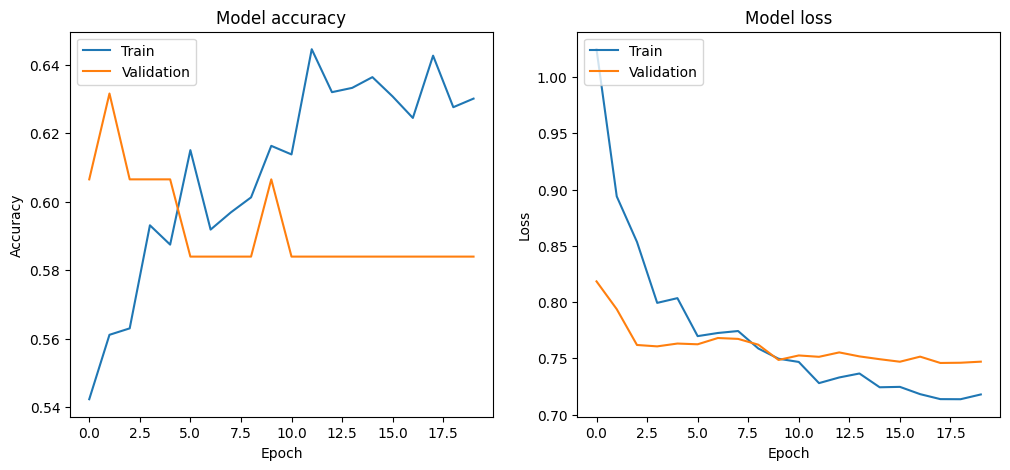

16/16 [==============================] - 0s 5ms/step - loss: 0.7296 - accuracy: 0.6152 - precision: 0.6152 - recall: 1.0000
Test Accuracy for Returns from day  3  : 61.52%
Test Precision for Returns from day  3  : 61.52%
Test Recall for Returns from day  3  : 100.00%
Test Loss for Returns from day  3  : 0.7296
Epoch 1/20
50/50 [==============================] - 12s 172ms/step - loss: 0.9675 - accuracy: 0.5937 - precision: 0.7354 - recall: 0.6977 - val_loss: 0.8117 - val_accuracy: 0.7068 - val_precision: 0.7068 - val_recall: 1.0000
Epoch 2/20
50/50 [==============================] - 3s 53ms/step - loss: 0.8006 - accuracy: 0.6621 - precision: 0.7334 - recall: 0.8480 - val_loss: 0.7399 - val_accuracy: 0.7068 - val_precision: 0.7068 - val_recall: 1.0000
Epoch 3/20
50/50 [==============================] - 3s 54ms/step - loss: 0.7626 - accuracy: 0.6671 - precision: 0.7312 - recall: 0.8642 - val_loss: 0.7415 - val_accuracy: 0.7068 - val_precision: 0.7068 - val_recall: 1.0000
Epoch 4/20
50/50 

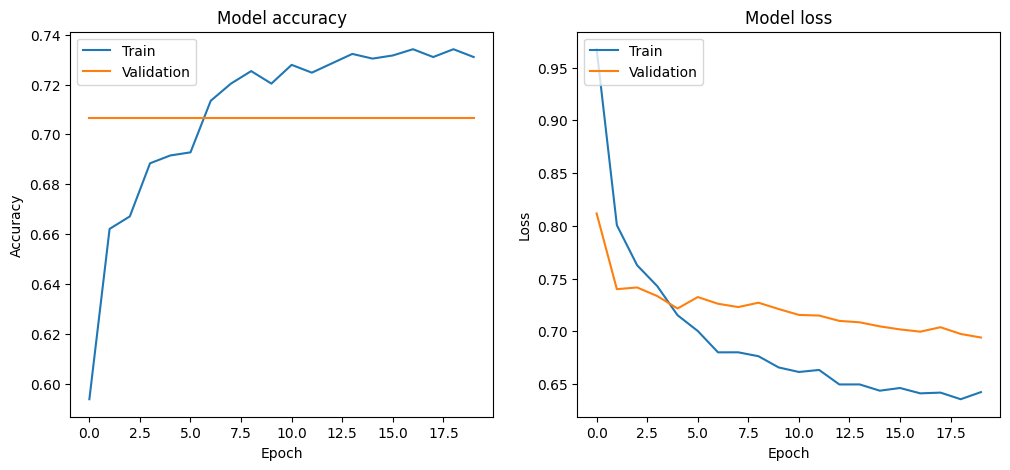

16/16 [==============================] - 0s 6ms/step - loss: 0.6872 - accuracy: 0.7234 - precision: 0.7234 - recall: 1.0000
Test Accuracy for Returns from day  4  : 72.34%
Test Precision for Returns from day  4  : 72.34%
Test Recall for Returns from day  4  : 100.00%
Test Loss for Returns from day  4  : 0.6872
Epoch 1/20
50/50 [==============================] - 13s 174ms/step - loss: 0.9984 - accuracy: 0.5862 - precision: 0.7928 - recall: 0.6536 - val_loss: 0.8270 - val_accuracy: 0.7444 - val_precision: 0.7444 - val_recall: 1.0000
Epoch 2/20
50/50 [==============================] - 4s 80ms/step - loss: 0.7200 - accuracy: 0.7361 - precision: 0.7967 - recall: 0.8997 - val_loss: 0.6852 - val_accuracy: 0.7444 - val_precision: 0.7444 - val_recall: 1.0000
Epoch 3/20
50/50 [==============================] - 2s 43ms/step - loss: 0.6814 - accuracy: 0.7517 - precision: 0.8026 - recall: 0.9146 - val_loss: 0.7082 - val_accuracy: 0.7444 - val_precision: 0.7444 - val_recall: 1.0000
Epoch 4/20
50/50 

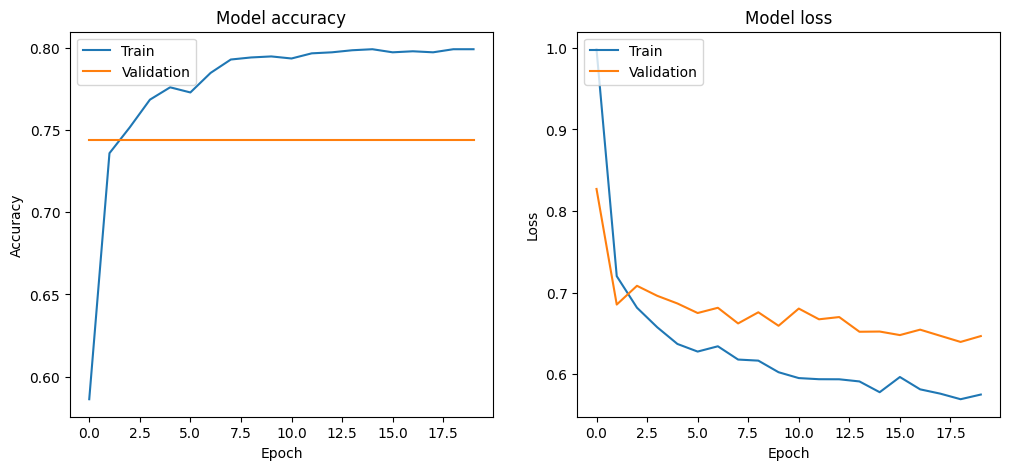

16/16 [==============================] - 0s 9ms/step - loss: 0.6136 - accuracy: 0.7916 - precision: 0.7916 - recall: 1.0000
Test Accuracy for Returns from day  5  : 79.16%
Test Precision for Returns from day  5  : 79.16%
Test Recall for Returns from day  5  : 100.00%
Test Loss for Returns from day  5  : 0.6136


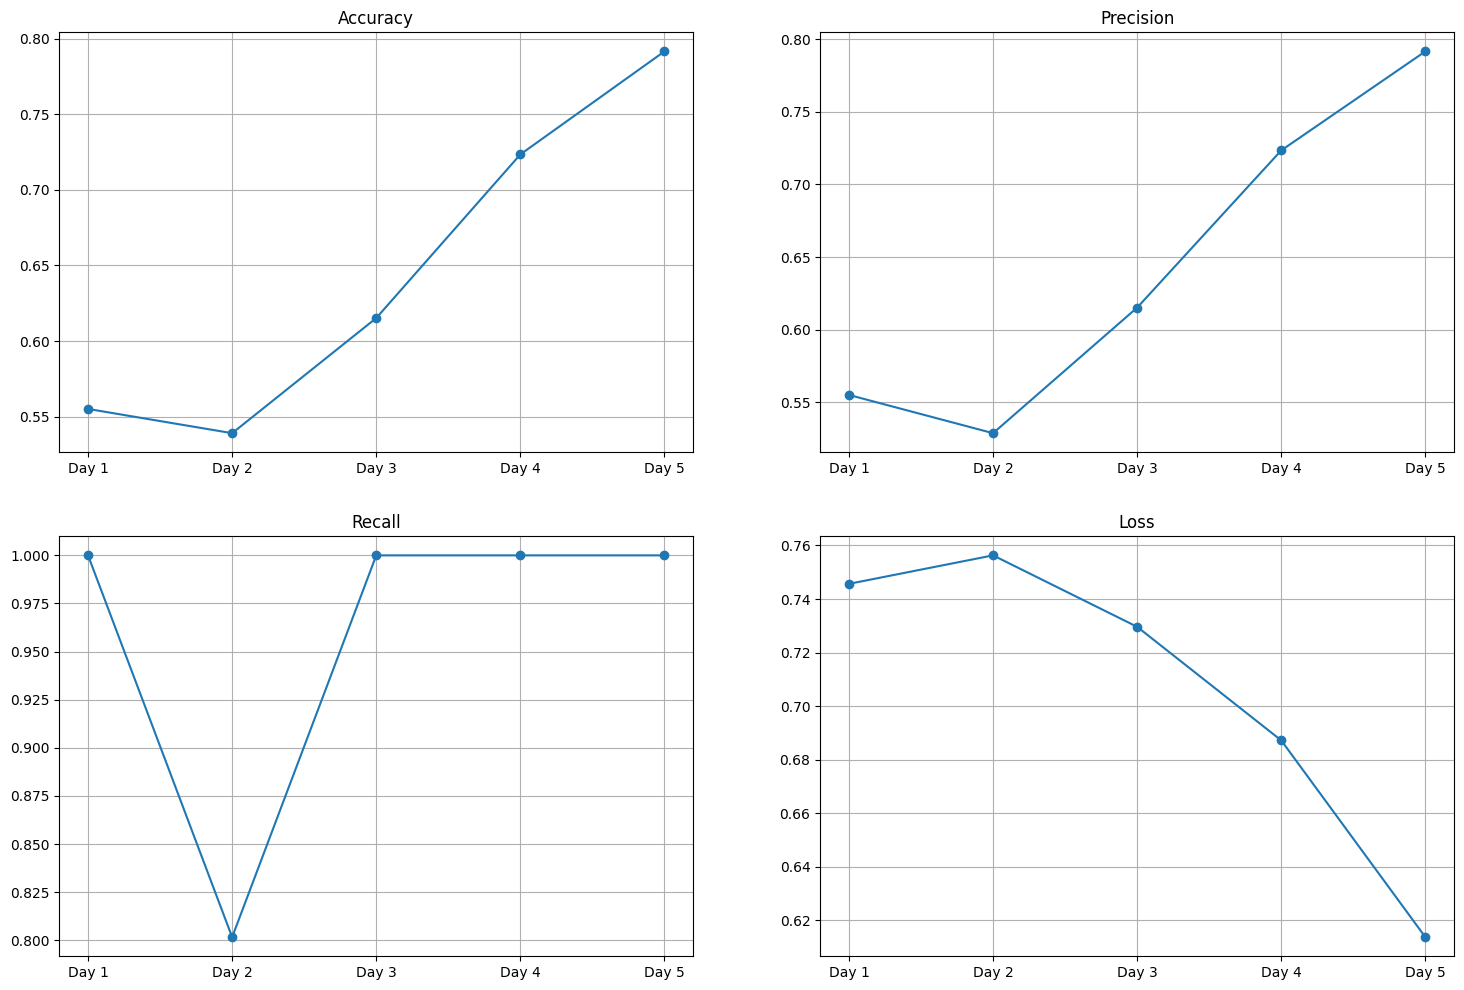

In [ ]:
print("=============  NEW GPT-3 LSTM  =============== \n")
accuracy =[]
precision=[]
recall =[]
loss=[]
for i in range(1,6):
  evaluation = model_LSTM_weekly(new_chatgpt,i)
  loss.append(evaluation[0])
  accuracy.append(evaluation[1])
  precision.append(evaluation[2])
  recall.append(evaluation[3])

plot_week_eval(accuracy,precision,recall,loss)

=============  HOT VADER LSTM  =============== 

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 32)]         0           []                               
                                                                                                  
 embedding_30 (Embedding)       (None, 32, 128)      1280000     ['text_input[0][0]']             
                                                                                                  
 market_input (InputLayer)      [(None, 5)]          0           []                               
                                                                                                  
 lstm_30 (LSTM)                 (None, 128)          131584      ['embedding_30[0][0]']           
                                          

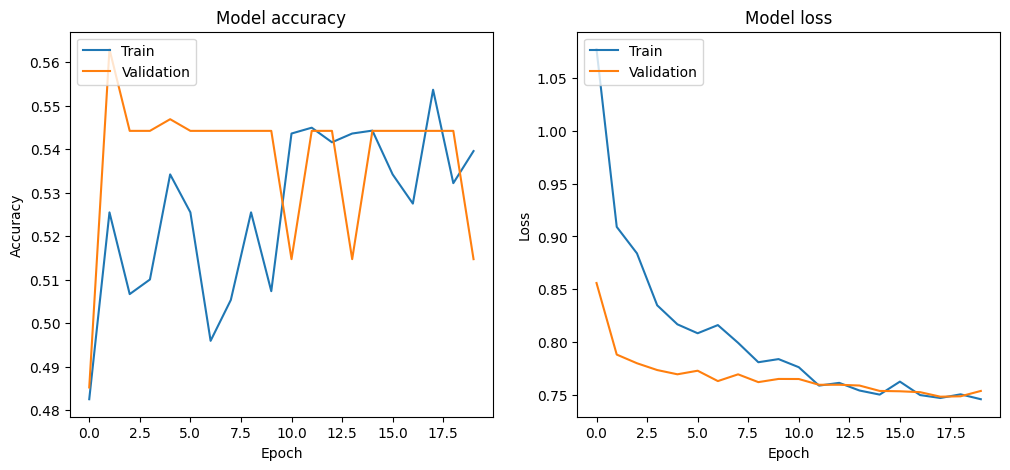

15/15 [==============================] - 0s 5ms/step - loss: 0.7455 - accuracy: 0.5451 - precision: 0.5468 - recall: 0.9084
Test Accuracy for Returns from day  1  : 54.51%
Test Precision for Returns from day  1  : 54.68%
Test Recall for Returns from day  1  : 90.84%
Test Loss for Returns from day  1  : 0.7455
Epoch 1/20
47/47 [==============================] - 13s 176ms/step - loss: 1.0637 - accuracy: 0.5154 - precision: 0.5468 - recall: 0.5427 - val_loss: 0.8379 - val_accuracy: 0.5147 - val_precision: 0.5797 - val_recall: 0.2083
Epoch 2/20
47/47 [==============================] - 4s 80ms/step - loss: 0.9293 - accuracy: 0.4960 - precision: 0.5258 - recall: 0.5766 - val_loss: 0.8101 - val_accuracy: 0.5282 - val_precision: 0.7000 - val_recall: 0.1458
Epoch 3/20
47/47 [==============================] - 2s 45ms/step - loss: 0.8701 - accuracy: 0.5268 - precision: 0.5545 - recall: 0.5817 - val_loss: 0.7824 - val_accuracy: 0.5282 - val_precision: 0.7000 - val_recall: 0.1458
Epoch 4/20
47/47 [

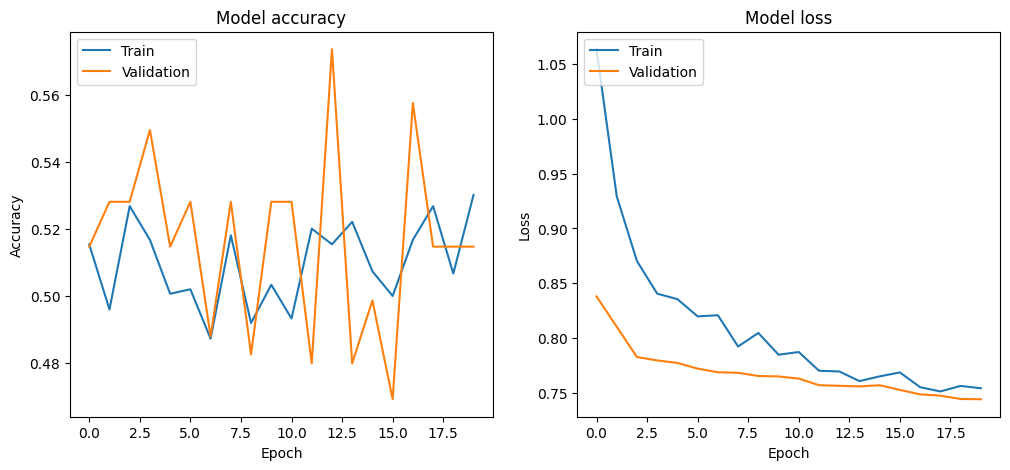

15/15 [==============================] - 0s 5ms/step - loss: 0.7434 - accuracy: 0.5021 - precision: 0.5021 - recall: 1.0000
Test Accuracy for Returns from day  2  : 50.21%
Test Precision for Returns from day  2  : 50.21%
Test Recall for Returns from day  2  : 100.00%
Test Loss for Returns from day  2  : 0.7434
Epoch 1/20
47/47 [==============================] - 12s 148ms/step - loss: 1.0016 - accuracy: 0.5611 - precision: 0.6250 - recall: 0.7305 - val_loss: 0.8375 - val_accuracy: 0.4075 - val_precision: 0.8276 - val_recall: 0.1000
Epoch 2/20
47/47 [==============================] - 3s 71ms/step - loss: 0.9065 - accuracy: 0.5443 - precision: 0.6174 - recall: 0.6970 - val_loss: 0.7690 - val_accuracy: 0.6408 - val_precision: 0.7023 - val_recall: 0.7667
Epoch 3/20
47/47 [==============================] - 4s 79ms/step - loss: 0.8396 - accuracy: 0.5631 - precision: 0.6301 - recall: 0.7154 - val_loss: 0.7462 - val_accuracy: 0.6434 - val_precision: 0.6434 - val_recall: 1.0000
Epoch 4/20
47/47 

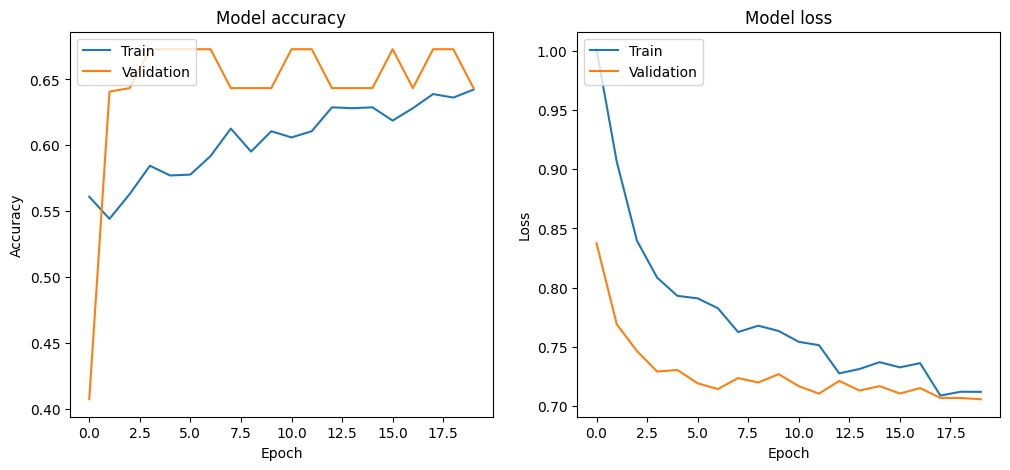

15/15 [==============================] - 0s 6ms/step - loss: 0.7106 - accuracy: 0.6330 - precision: 0.6330 - recall: 1.0000
Test Accuracy for Returns from day  3  : 63.30%
Test Precision for Returns from day  3  : 63.30%
Test Recall for Returns from day  3  : 100.00%
Test Loss for Returns from day  3  : 0.7106
Epoch 1/20
47/47 [==============================] - 13s 170ms/step - loss: 0.9103 - accuracy: 0.6228 - precision: 0.7072 - recall: 0.7922 - val_loss: 0.8508 - val_accuracy: 0.6676 - val_precision: 0.6676 - val_recall: 1.0000
Epoch 2/20
47/47 [==============================] - 4s 87ms/step - loss: 0.8160 - accuracy: 0.6309 - precision: 0.7024 - recall: 0.8255 - val_loss: 0.7472 - val_accuracy: 0.6676 - val_precision: 0.6676 - val_recall: 1.0000
Epoch 3/20
47/47 [==============================] - 4s 90ms/step - loss: 0.7871 - accuracy: 0.6436 - precision: 0.7017 - recall: 0.8589 - val_loss: 0.7441 - val_accuracy: 0.6676 - val_precision: 0.6676 - val_recall: 1.0000
Epoch 4/20
47/47 

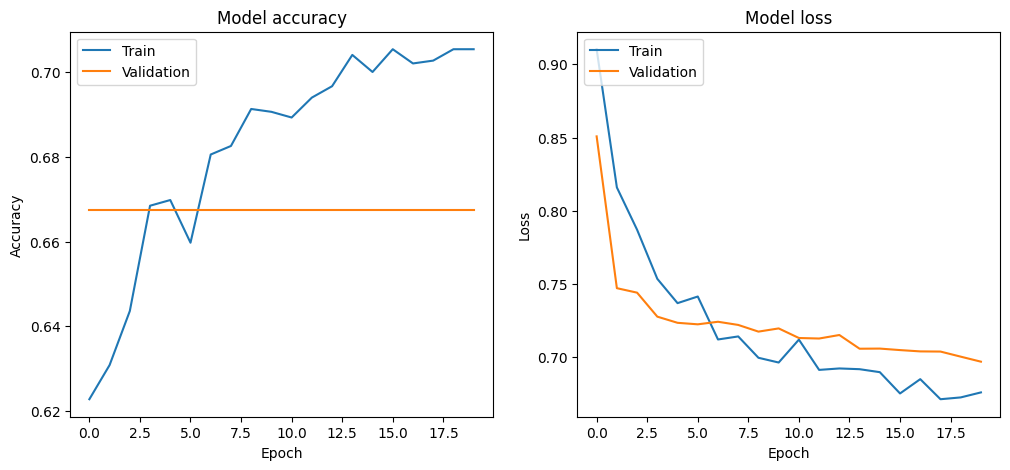

15/15 [==============================] - 0s 5ms/step - loss: 0.6843 - accuracy: 0.6867 - precision: 0.6867 - recall: 1.0000
Test Accuracy for Returns from day  4  : 68.67%
Test Precision for Returns from day  4  : 68.67%
Test Recall for Returns from day  4  : 100.00%
Test Loss for Returns from day  4  : 0.6843
Epoch 1/20
47/47 [==============================] - 13s 174ms/step - loss: 0.9048 - accuracy: 0.6376 - precision: 0.7885 - recall: 0.7374 - val_loss: 0.6984 - val_accuracy: 0.7694 - val_precision: 0.7694 - val_recall: 1.0000
Epoch 2/20
47/47 [==============================] - 5s 118ms/step - loss: 0.7532 - accuracy: 0.7409 - precision: 0.7900 - recall: 0.9139 - val_loss: 0.6897 - val_accuracy: 0.7694 - val_precision: 0.7694 - val_recall: 1.0000
Epoch 3/20
47/47 [==============================] - 2s 48ms/step - loss: 0.6936 - accuracy: 0.7537 - precision: 0.7908 - recall: 0.9344 - val_loss: 0.6695 - val_accuracy: 0.7694 - val_precision: 0.7694 - val_recall: 1.0000
Epoch 4/20
47/47

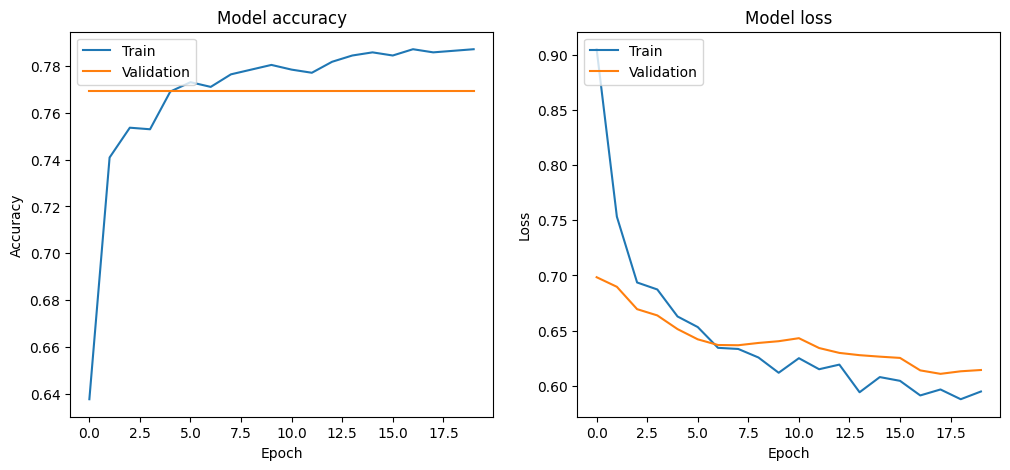

15/15 [==============================] - 0s 6ms/step - loss: 0.5903 - accuracy: 0.7918 - precision: 0.7918 - recall: 1.0000
Test Accuracy for Returns from day  5  : 79.18%
Test Precision for Returns from day  5  : 79.18%
Test Recall for Returns from day  5  : 100.00%
Test Loss for Returns from day  5  : 0.5903


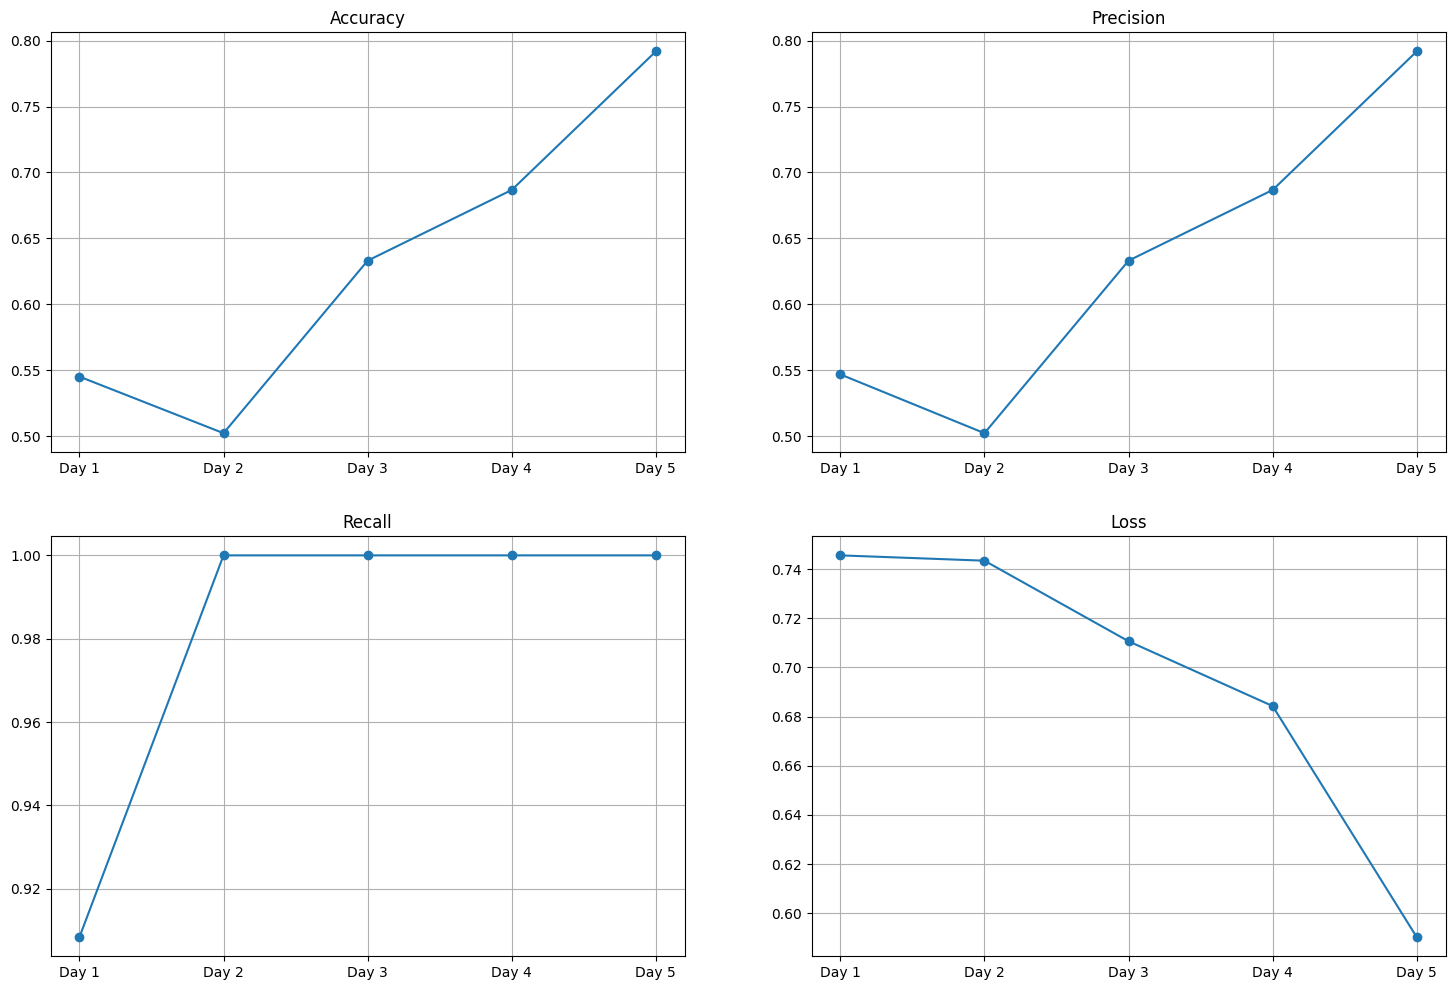

In [ ]:
print("=============  HOT VADER LSTM  =============== \n")
accuracy =[]
precision=[]
recall =[]
loss=[]
for i in range(1,6):
  evaluation = model_LSTM_weekly_vader(hot_vader,i)
  loss.append(evaluation[0])
  accuracy.append(evaluation[1])
  precision.append(evaluation[2])
  recall.append(evaluation[3])

plot_week_eval(accuracy,precision,recall,loss)

=============  NEW VADER LSTM  =============== 

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 34)]         0           []                               
                                                                                                  
 embedding_35 (Embedding)       (None, 34, 128)      1280000     ['text_input[0][0]']             
                                                                                                  
 market_input (InputLayer)      [(None, 5)]          0           []                               
                                                                                                  
 lstm_35 (LSTM)                 (None, 128)          131584      ['embedding_35[0][0]']           
                                          

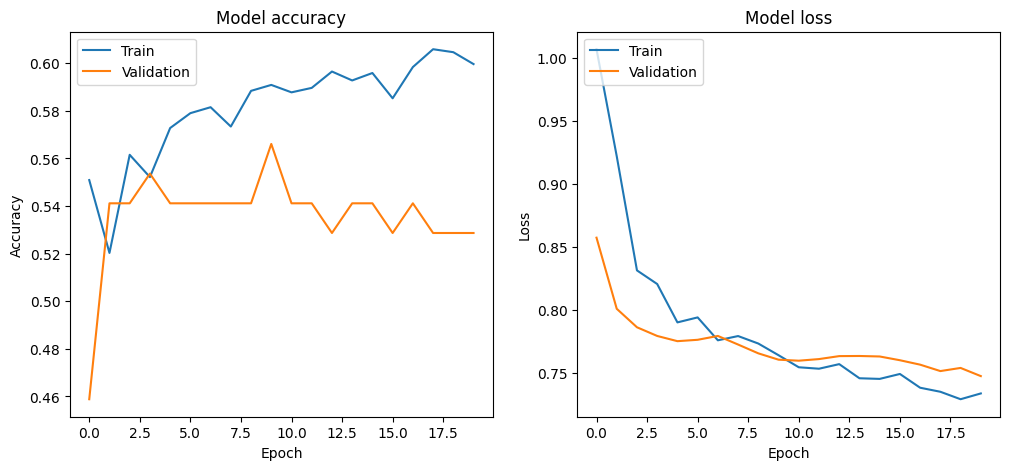

16/16 [==============================] - 0s 6ms/step - loss: 0.7406 - accuracy: 0.5549 - precision: 0.5549 - recall: 1.0000
Test Accuracy for Returns from day  1  : 55.49%
Test Precision for Returns from day  1  : 55.49%
Test Recall for Returns from day  1  : 100.00%
Test Loss for Returns from day  1  : 0.7406
Epoch 1/20
51/51 [==============================] - 13s 178ms/step - loss: 1.0277 - accuracy: 0.5072 - precision: 0.5452 - recall: 0.6239 - val_loss: 0.8315 - val_accuracy: 0.4838 - val_precision: 0.4262 - val_recall: 0.1313
Epoch 2/20
51/51 [==============================] - 4s 74ms/step - loss: 0.8952 - accuracy: 0.5172 - precision: 0.5561 - recall: 0.6023 - val_loss: 0.8013 - val_accuracy: 0.4938 - val_precision: 0.4938 - val_recall: 1.0000
Epoch 3/20
51/51 [==============================] - 3s 56ms/step - loss: 0.8750 - accuracy: 0.5097 - precision: 0.5505 - recall: 0.5886 - val_loss: 0.7976 - val_accuracy: 0.4938 - val_precision: 0.4938 - val_recall: 1.0000
Epoch 4/20
51/51 

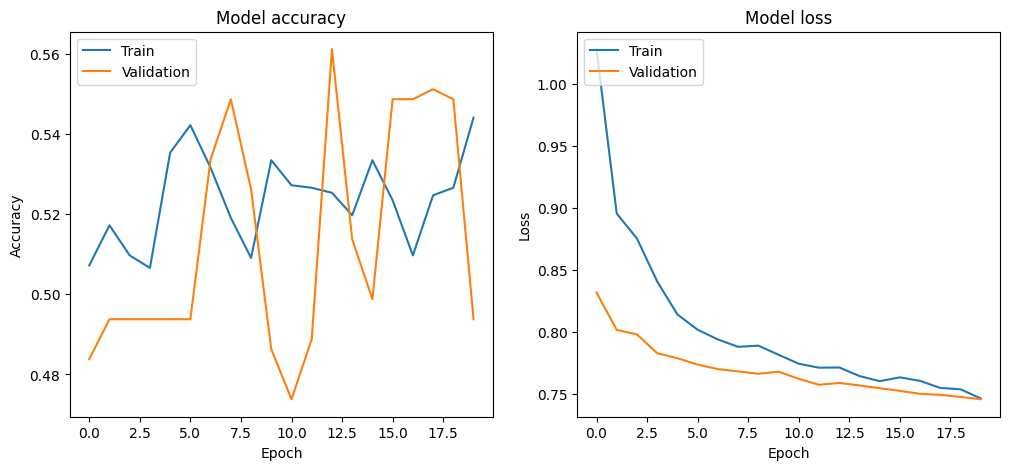

16/16 [==============================] - 0s 6ms/step - loss: 0.7445 - accuracy: 0.5070 - precision: 0.5070 - recall: 1.0000
Test Accuracy for Returns from day  2  : 50.70%
Test Precision for Returns from day  2  : 50.70%
Test Recall for Returns from day  2  : 100.00%
Test Loss for Returns from day  2  : 0.7445
Epoch 1/20
51/51 [==============================] - 14s 184ms/step - loss: 0.9985 - accuracy: 0.5553 - precision: 0.6432 - recall: 0.6673 - val_loss: 0.8229 - val_accuracy: 0.5761 - val_precision: 0.5761 - val_recall: 1.0000
Epoch 2/20
51/51 [==============================] - 4s 80ms/step - loss: 0.8871 - accuracy: 0.5540 - precision: 0.6277 - recall: 0.7256 - val_loss: 0.7781 - val_accuracy: 0.6010 - val_precision: 0.5908 - val_recall: 1.0000
Epoch 3/20
51/51 [==============================] - 4s 87ms/step - loss: 0.8378 - accuracy: 0.5671 - precision: 0.6356 - recall: 0.7404 - val_loss: 0.7626 - val_accuracy: 0.6010 - val_precision: 0.5908 - val_recall: 1.0000
Epoch 4/20
51/51 

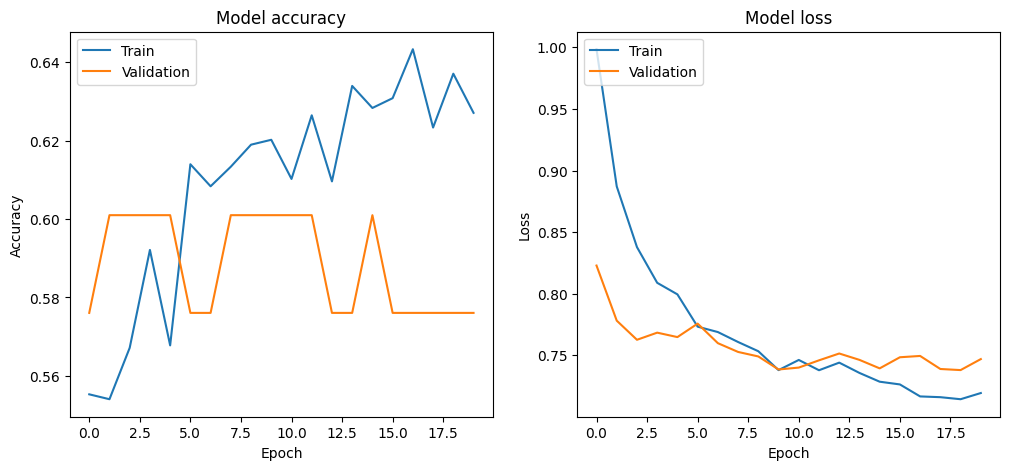

16/16 [==============================] - 0s 6ms/step - loss: 0.7280 - accuracy: 0.6088 - precision: 0.6088 - recall: 1.0000
Test Accuracy for Returns from day  3  : 60.88%
Test Precision for Returns from day  3  : 60.88%
Test Recall for Returns from day  3  : 100.00%
Test Loss for Returns from day  3  : 0.7280
Epoch 1/20
51/51 [==============================] - 13s 145ms/step - loss: 0.8880 - accuracy: 0.6790 - precision: 0.7524 - recall: 0.8450 - val_loss: 0.7572 - val_accuracy: 0.7032 - val_precision: 0.7032 - val_recall: 1.0000
Epoch 2/20
51/51 [==============================] - 3s 54ms/step - loss: 0.7842 - accuracy: 0.6889 - precision: 0.7480 - recall: 0.8753 - val_loss: 0.7230 - val_accuracy: 0.7032 - val_precision: 0.7032 - val_recall: 1.0000
Epoch 3/20
51/51 [==============================] - 5s 91ms/step - loss: 0.7411 - accuracy: 0.6933 - precision: 0.7364 - recall: 0.9132 - val_loss: 0.7565 - val_accuracy: 0.7032 - val_precision: 0.7032 - val_recall: 1.0000
Epoch 4/20
51/51 

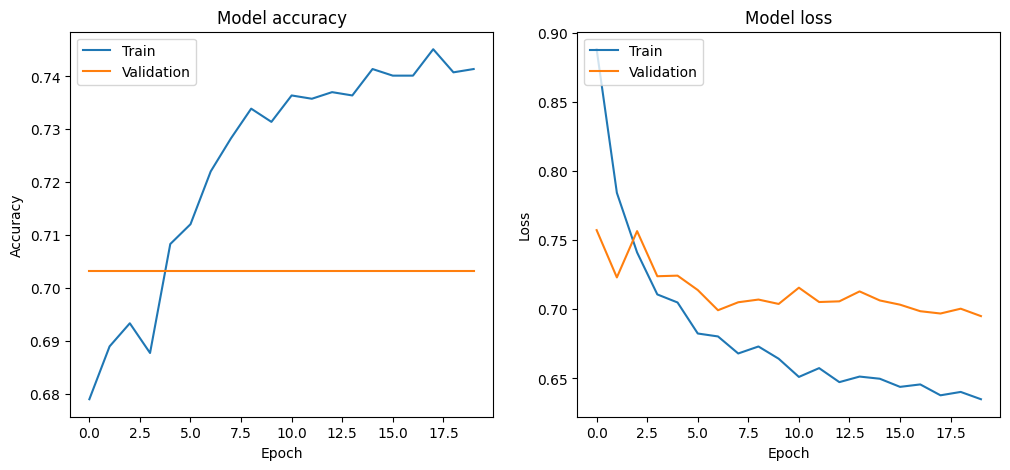

16/16 [==============================] - 0s 8ms/step - loss: 0.6926 - accuracy: 0.7066 - precision: 0.7066 - recall: 1.0000
Test Accuracy for Returns from day  4  : 70.66%
Test Precision for Returns from day  4  : 70.66%
Test Recall for Returns from day  4  : 100.00%
Test Loss for Returns from day  4  : 0.6926
Epoch 1/20
51/51 [==============================] - 12s 158ms/step - loss: 0.8814 - accuracy: 0.6477 - precision: 0.8087 - recall: 0.7372 - val_loss: 0.7366 - val_accuracy: 0.7456 - val_precision: 0.7456 - val_recall: 1.0000
Epoch 2/20
51/51 [==============================] - 4s 82ms/step - loss: 0.7174 - accuracy: 0.7427 - precision: 0.8053 - recall: 0.8977 - val_loss: 0.7275 - val_accuracy: 0.7456 - val_precision: 0.7456 - val_recall: 1.0000
Epoch 3/20
51/51 [==============================] - 3s 52ms/step - loss: 0.6628 - accuracy: 0.7764 - precision: 0.8082 - recall: 0.9473 - val_loss: 0.7873 - val_accuracy: 0.3317 - val_precision: 0.6372 - val_recall: 0.2408
Epoch 4/20
51/51 

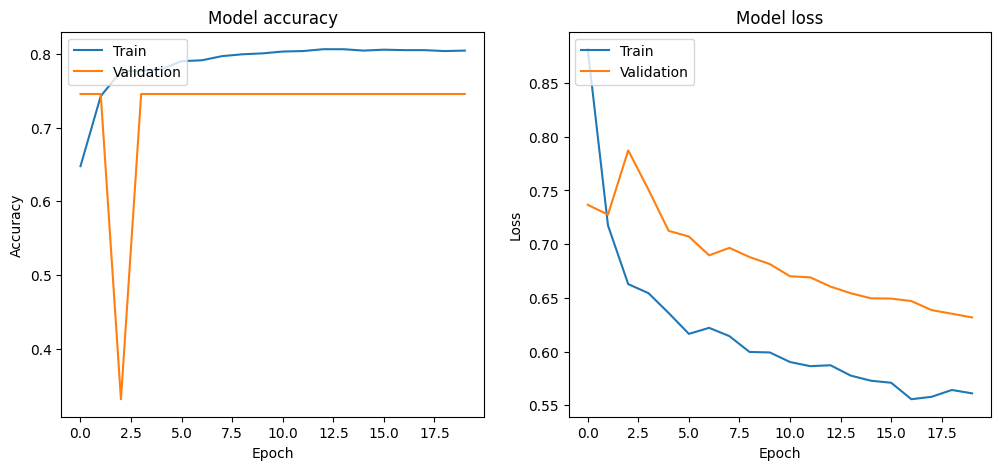

16/16 [==============================] - 0s 8ms/step - loss: 0.6096 - accuracy: 0.7725 - precision: 0.7725 - recall: 1.0000
Test Accuracy for Returns from day  5  : 77.25%
Test Precision for Returns from day  5  : 77.25%
Test Recall for Returns from day  5  : 100.00%
Test Loss for Returns from day  5  : 0.6096


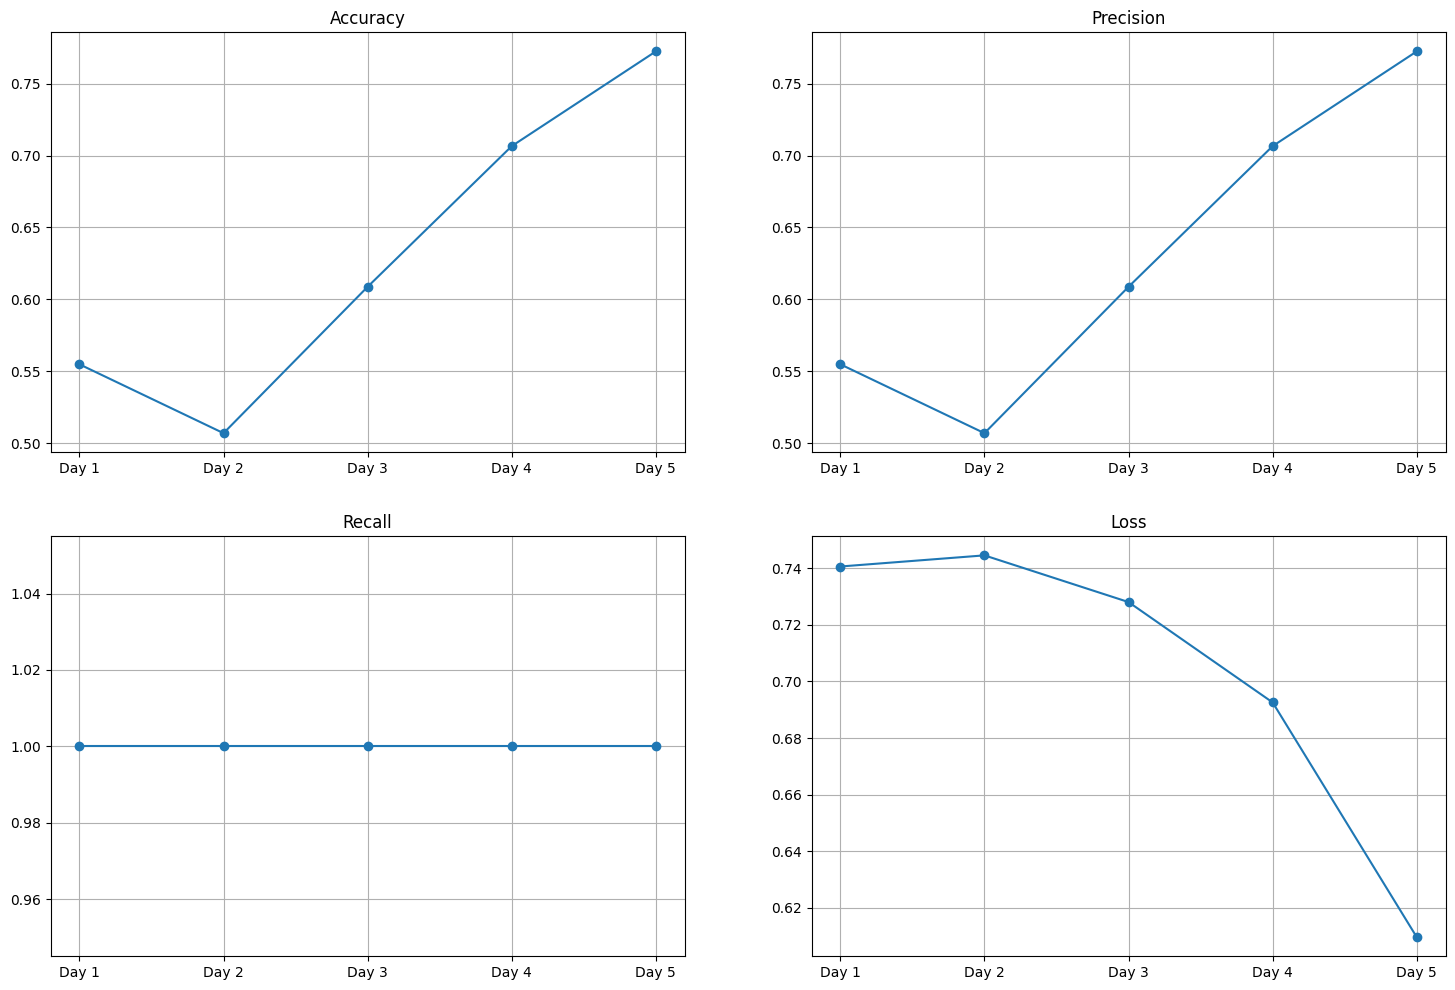

In [ ]:
print("=============  NEW VADER LSTM  =============== \n")
accuracy =[]
precision=[]
recall =[]
loss=[]
for i in range(1,6):
  evaluation = model_LSTM_weekly_vader(new_vader,i)
  loss.append(evaluation[0])
  accuracy.append(evaluation[1])
  precision.append(evaluation[2])
  recall.append(evaluation[3])

plot_week_eval(accuracy,precision,recall,loss)